# Exploratory Data Analysis of Stimulus Triggered Averages
*Ian Malone*

#### Analysis plan

- Given raw evoked potential time series
- Find locations of delivered stimuli
- Capture 40 ms of evoked potential waveform
- Account for differences in recording ampltiudes between animal cohorts
- Save these data to a MEP dataframe along with other information (Animal, Day, Stimulus Amplitude, Diaphragm Side, Sample)
- Average MEPs to create STA dataframe. Both the MEP and STA dataframe contain time series
- Export these dataframes as .csv files for further analysis


_This is where the analysis in this notebook begins. Above analysis was completed in a separate script "mep-to-sta-batch.py"_
- Visually inspect raw STAs by plotting
- Remove bad data
- Align days properly (different animals had measurements on different days)
- Remove stimulus artifact
- Scale the STAs to be in [0,1]
- Capture metric of choice (peak-to-peak amplitude)
- Check to make sure the distribution of data is preserved after scaling
- Explore all variables not controlled for and pool if possible (e.g., # hours stim, time between stim and measurement, time of day, day postop)
- Plot group data with fit lines to check if phenomenon seems to be present
- Fit these data to a linear mixed effect model to test for significant differences

#### Load data and check structure

In [213]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

filename = 'df_STA_NEIL_2021_03_01'

project = 'NEIL' if 'NEIL' in filename else 'SPARC'
path = 'D:\\Dataframe_CSVs\\%s.csv' % filename

df_sta = pd.read_csv(path)

#### Add 'Time' column based on 'Sample' and a sampling frequency of 5000 Hz

In [214]:
sampling_frequency = 5000 # hertz
df_sta['Time'] = df_sta['Sample']/sampling_frequency # create time column based on samples and sampling frequency
df_sta['Time'] = df_sta['Time']*1000
df_sta = df_sta.drop(columns=['Sample'])
df_sta.head()

,Animal,Day_Postop,Day_Stim,Side,Stim_Amplitude,STA_Amplitude,Time
0,N01,999,1,Left,10.0,-0.014575,0.0
1,N01,999,1,Left,10.0,-0.007710,0.2
2,N01,999,1,Left,10.0,-0.002015,0.4
3,N01,999,1,Left,10.0,-0.001218,0.6
4,N01,999,1,Left,10.0,-0.003526,0.8


#### Drop 'Day_Postop' feature for now

In [215]:
df_sta = df_sta.drop(['Day_Postop'], axis=1)

#### Define function to add group information to dataframe

In [216]:
### groups for NEIL project
injstim = ['N09','N10','N11','N13','N27','N28','N29','N30','N34']
noinjstim = ['N01','N04','N05','N31','N32','N33','N35'] 
injnostim = ['N14','N15','N16','N21','N22','N23','N36','N37']
noinjnostim = ['N17','N19','N20','N24','N25','N26','N38','N39'] 

### groups for SPARC project
groupa = ['S01', 'S02']
groupb = ['S03', 'S04']
groupc = ['S05', 'S06']

# add animal group information to the dataframe
# make a function so you can apply to multiple dataframes
def add_group(df):
    '''This function adds Group column to dataframe based on Animal column'''
    if project == 'NEIL':
        conditions = [
            (df['Animal'].isin(injstim)),
            (df['Animal'].isin(noinjstim)),
            (df['Animal'].isin(injnostim)),
            (df['Animal'].isin(noinjnostim)) ]
        choices = ['Yes Injury, Yes EES', 'No Injury, Yes EES', 'Yes Injury, No EES', 'No Injury, No EES']
        df['Group'] = np.select(conditions, choices)
    elif project == 'SPARC':
        conditions = [
            (df['Animal'].isin(groupa)),
            (df['Animal'].isin(groupb)),
            (df['Animal'].isin(groupc)) ]
        choices = ['Group A', 'Group B', 'Group C']
        df['Group'] = np.select(conditions, choices)       

#### Check raw STAs by plotting

In [217]:
# g = sns.FacetGrid(df_sta[(df_sta['Stim_Amplitude'] % 10 == 0) & (df_sta['Side'] == 'Left')], col='Day_Stim', row='Animal', hue='Stim_Amplitude')
# g.map_dataframe(sns.lineplot, x='Time', y='STA_Amplitude')
# g.set_axis_labels('Time (ms)', 'Ampltiude (V)')
# g.add_legend()
# ax.figure.savefig("D:\\raw_stas.png")

#### Adjust days so they are properly aligned

In [218]:
# we will call day 1 the day when baseline (no stimulation yet) measurements
# were taken
# early animals were recorded in this way
# recent animals had this called day 0... change that here
recent_animals = ['N27','N28','N29','N30','N31','N32','N33','N34']

df_sta.loc[df_sta['Animal'].isin(recent_animals), 'Day_Stim']+=1
df_sta = df_sta[df_sta['Day_Stim'] < 5]

#### Based on the plotted STAs, remove unusable data from dataframe

In [219]:
# delete N29 from dataframe (recordings were badly messed up)
df_sta = df_sta[df_sta['Animal'] != 'N29']

#### Keep only the side of interest for analysis

In [220]:
if 'NEIL' in path: 
    df_sta = df_sta[df_sta["Side"] == 'Left']
else:
    df_sta = df_sta[df_sta["Side"] == 'Right']

#### Remove stimulus artifact

In [221]:
# remove the stimulus artifact
df_sta_noart = df_sta.copy()
df_sta_noart = df_sta_noart[df_sta_noart['Time'] > 2.5]

#### Plot cleaned STAs

In [222]:
# g = sns.FacetGrid(df_sta_noart[(df_sta_noart['Stim_Amplitude'] % 10 == 0)], col='Day_Stim', row='Animal', hue='Stim_Amplitude')
# g.map_dataframe(sns.lineplot, x='Time', y='STA_Amplitude')
# g.set_axis_labels('Time (ms)', 'Ampltiude (V)')
# g.add_legend()
# ax.figure.savefig("D:\\cleaned_stas.png")

#### Scale the STAs to occupy [0,1]

In [223]:
df_scaled = df_sta_noart.copy()

# for easier scaling, reshape the dataframe from long to wide format
df_scaled = df_scaled.pivot_table(index=['Day_Stim', 'Stim_Amplitude', 'Time'], 
                    columns='Animal', 
                    values='STA_Amplitude')

In [224]:
# import the scaler and perfrom 0-1 rescaling
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_scaled[df_scaled.columns] = scaler.fit_transform(df_scaled[df_scaled.columns])

In [225]:
# convert dataframe back to long format
animal_cols = df_scaled.columns
df_scaled.reset_index(inplace=True)
df_scaled.columns.name = None
df_sta_scaled = pd.melt(df_scaled, id_vars=['Day_Stim', 'Stim_Amplitude', 'Time'], value_vars=animal_cols, var_name='Animal', value_name='STA_Amplitude')

#### Plot the normalized STAs

In [226]:
# g = sns.FacetGrid(df_sta_scaled[(df_sta_scaled['Stim_Amplitude'] % 10 == 0)], col='Day_Stim', row='Animal', hue='Stim_Amplitude')
# g.map_dataframe(sns.lineplot, x='Time', y='STA_Amplitude')
# g.set_axis_labels('Time (ms)', 'Ampltiude (V)')
# g.add_legend()
# ax.figure.savefig("D:\\normed_stas.png")

#### Make example figures for proposal ("What is a MEP/STA?")

<Figure size 432x288 with 0 Axes>

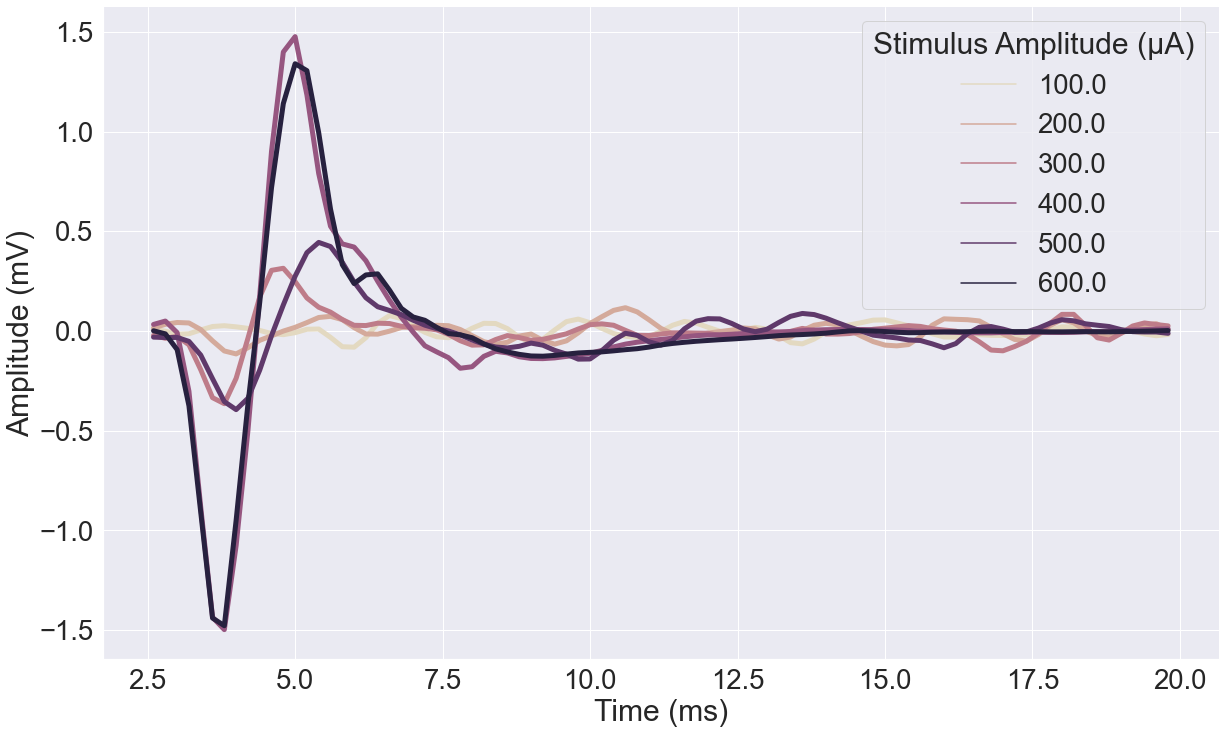

In [227]:
sns.set(font_scale=2.5)
sns.set_style("darkgrid")
sns.despine()
pal = sns.color_palette("ch:s=-.2,r=.6", as_cmap=True)
plt.figure(figsize=(20,12))
stimamplist = [100,200,300,400,500,600]

ax = sns.lineplot(data=df_sta_noart[(df_sta_noart['Animal'] == 'N11') & (df_sta_noart['Day_Stim'] == 4) 
                               & (df_sta_noart['Stim_Amplitude'].isin(stimamplist))
                               & (df_sta_noart['Time'] < 20)], 
             x="Time", y="STA_Amplitude", palette=pal, hue="Stim_Amplitude", linewidth=5, legend=True)
ax.set(xlabel='Time (ms)', ylabel='Amplitude (mV)')
ax.legend().set_title('Stimulus Amplitude (μA)')
sns.despine()
ax.figure.savefig("D:\\single_sta.png")

<Figure size 432x288 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

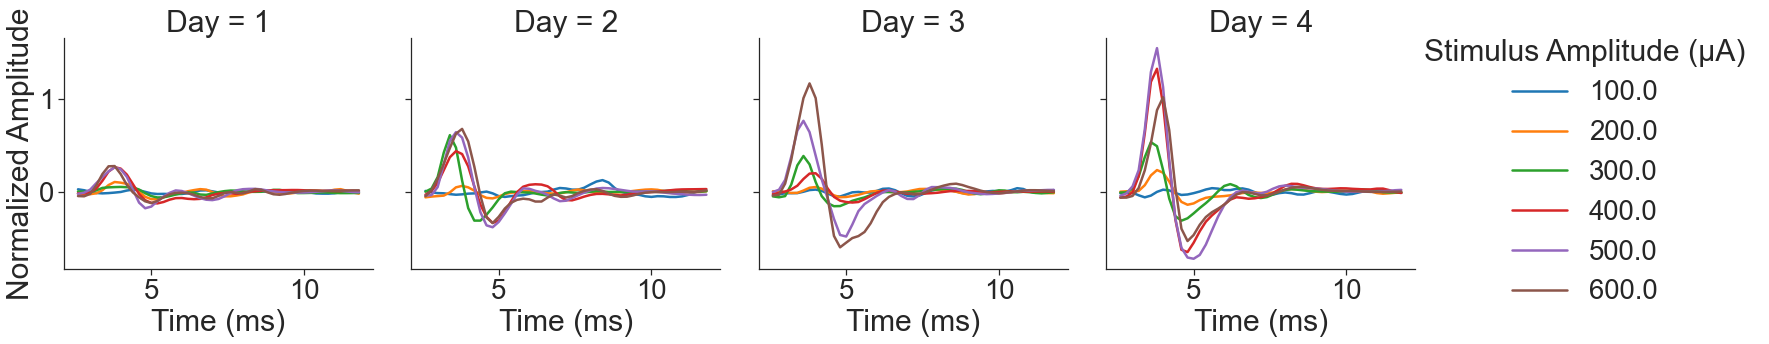

In [228]:
sns.set(font_scale=2.5)
sns.set_style("ticks")
sns.despine()
plt.figure(figsize=(24,12))
stimlist = [100, 200,300, 400, 500, 600]
animallist = ['N27']
daylist=[1,2,3,4]

df_example = df_sta_noart.copy()
df_example = df_example.rename(columns={'Stim_Amplitude':'Stimulus Amplitude (μA)', 'Day_Stim':'Day'})


g = sns.FacetGrid(df_example[(df_example['Stimulus Amplitude (μA)'].isin(stimlist)) & (df_example['Time'] < 30) 
                               & (df_example['Animal'].isin(animallist)) 
                               & (df_example['Day'].isin(daylist))
                               & (df_example['Side'] == 'Left')
                               & (df_example['Time'] < 12)], 
                  col='Day', palette='tab10', hue='Stimulus Amplitude (μA)', height=5)

g.map_dataframe(sns.lineplot, x='Time', y='STA_Amplitude', linewidth=2.5)
g.set_axis_labels('Time (ms)', 'Normalized Amplitude')
g.add_legend()
g.savefig("D:\\sta_over_time.png")


### Peak-to-peak (p2p) amplitude analysis

In [229]:
# make dataframe from the raw data and the scaled data to check if distribution is preserved later

df_p2p_scaled = df_sta_scaled.copy()
df_p2p = df_sta_noart.copy()
df_p2p.head()

,Animal,Day_Stim,Side,Stim_Amplitude,STA_Amplitude,Time
13,N01,1,Left,10.0,-0.011118,2.6
14,N01,1,Left,10.0,-0.015516,2.8
15,N01,1,Left,10.0,-0.013481,3.0
16,N01,1,Left,10.0,-0.009265,3.2
17,N01,1,Left,10.0,-0.004450,3.4


#### Calclated p2p amplitude

In [230]:
df_p2p = df_p2p.groupby(['Animal', 'Day_Stim', 'Stim_Amplitude'])['STA_Amplitude'].apply(lambda x: x.max() - x.min()).reset_index().rename(columns={'STA_Amplitude':'p2p_amplitude'})
df_p2p_scaled = df_p2p_scaled.groupby(['Animal', 'Day_Stim', 'Stim_Amplitude'])['STA_Amplitude'].apply(lambda x: x.max() - x.min()).reset_index().rename(columns={'STA_Amplitude':'p2p_amplitude_scaled'})


#### Convert all p2p amplitudes into ratios of the animal's max p2p amplitude over all 4 days

In [231]:
# Convert all p2p amplitudes into ratios of the animal's max p2p amplitude

### YOU MAY HAVE TO GROUP THEM ON SIDE AS WELL FOR EACH ANIMAL
 
df_p2p_ratio_max = df_p2p.merge(df_p2p.groupby(['Animal'])['p2p_amplitude'].max(), on='Animal', how='left')
df_p2p_ratio_max['p2p_amplitude_ratio_max'] = df_p2p_ratio_max['p2p_amplitude_x'] / df_p2p_ratio_max['p2p_amplitude_y']
df_p2p_ratio_max = df_p2p_ratio_max.drop(columns=['p2p_amplitude_x', 'p2p_amplitude_y'])

#### Add group information to dataframes

In [232]:
add_group(df_p2p)
add_group(df_p2p_scaled)
add_group(df_p2p_ratio_max)
df_p2p_ratio_max.head()

,Animal,Day_Stim,Stim_Amplitude,p2p_amplitude_ratio_max,Group
0,N01,1,10.0,0.045521,"No Injury, Yes EES"
1,N01,1,20.0,0.046879,"No Injury, Yes EES"
2,N01,1,30.0,0.049342,"No Injury, Yes EES"
3,N01,1,40.0,0.063211,"No Injury, Yes EES"
4,N01,1,50.0,0.087493,"No Injury, Yes EES"


In [233]:
df_p2p_scaled.head()

,Animal,Day_Stim,Stim_Amplitude,p2p_amplitude_scaled,Group
0,N01,1,10.0,0.044218,"No Injury, Yes EES"
1,N01,1,15.0,NaN,"No Injury, Yes EES"
2,N01,1,20.0,0.045537,"No Injury, Yes EES"
3,N01,1,25.0,NaN,"No Injury, Yes EES"
4,N01,1,30.0,0.047929,"No Injury, Yes EES"


#### Make plots to compare the distribution of p2p, p2p_scaled, p2p_ratio_max

<Figure size 432x288 with 0 Axes>

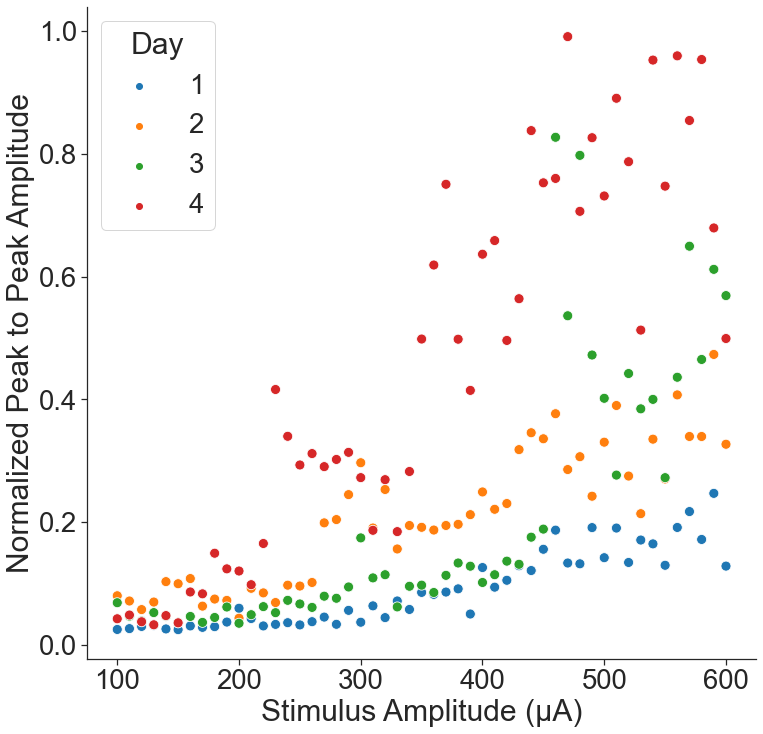

In [243]:
# Representative plot for presentations

sns.set(font_scale=2.5)
sns.set_style("ticks")
sns.despine()
plt.figure(figsize=(12,12))


ax = sns.scatterplot(data=df_p2p_scaled[(df_p2p_scaled['Animal']=='N27')], 
                x='Stim_Amplitude', y='p2p_amplitude_scaled', palette='tab10', hue='Day_Stim', s=100)
ax.set(xlabel='Stimulus Amplitude (μA)', ylabel='Normalized Peak to Peak Amplitude')
ax.legend().set_title('Day')
sns.despine()
ax.figure.savefig("D:\\N27_representative.png")

<Figure size 432x288 with 0 Axes>

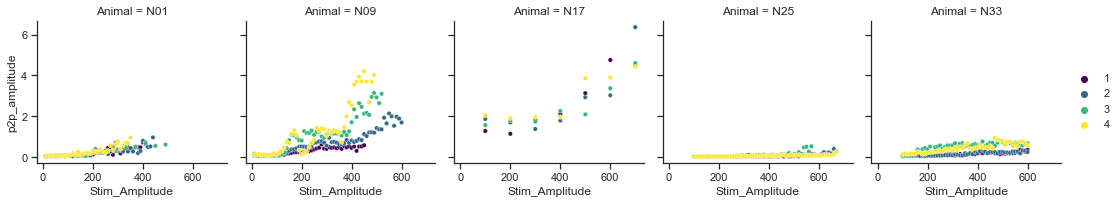

In [235]:
sns.set(font_scale=1)
sns.set_style("ticks")
sns.despine()

animals = ['N01','N09','N17','N25','N33']

g = sns.FacetGrid(df_p2p[df_p2p['Animal'].isin(animals)], col="Animal")
g = (g.map(sns.scatterplot, "Stim_Amplitude", "p2p_amplitude", 'Day_Stim', palette='viridis',s=20).add_legend())

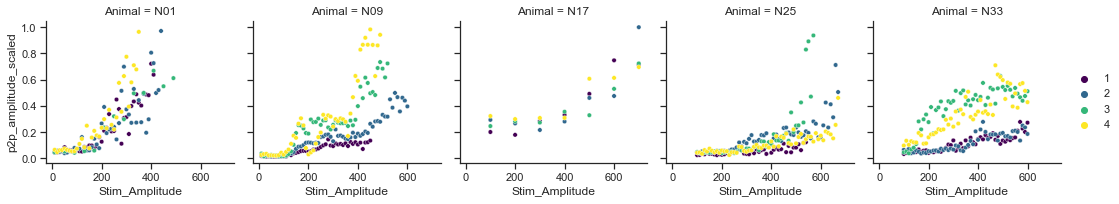

In [236]:
g = sns.FacetGrid(df_p2p_scaled[df_p2p_scaled['Animal'].isin(animals)], col="Animal")
g = (g.map(sns.scatterplot, "Stim_Amplitude", "p2p_amplitude_scaled", 'Day_Stim', palette='viridis',s=20).add_legend())


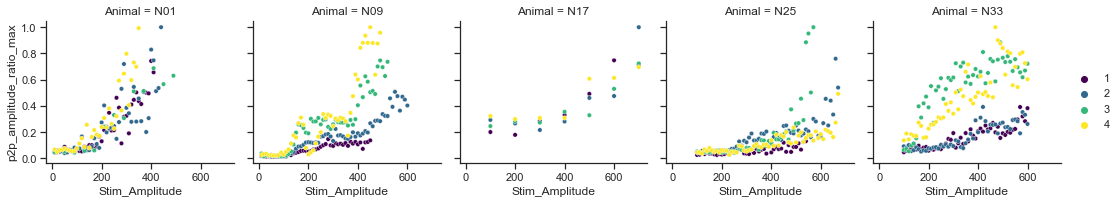

In [237]:
g = sns.FacetGrid(df_p2p_ratio_max[df_p2p_ratio_max['Animal'].isin(animals)], col="Animal")
g = (g.map(sns.scatterplot, "Stim_Amplitude", "p2p_amplitude_ratio_max", 'Day_Stim', palette='viridis',s=20).add_legend())


#### Fit lines by group and day to visualize change over time (and stim amplitude) for each group

<Figure size 1728x864 with 0 Axes>

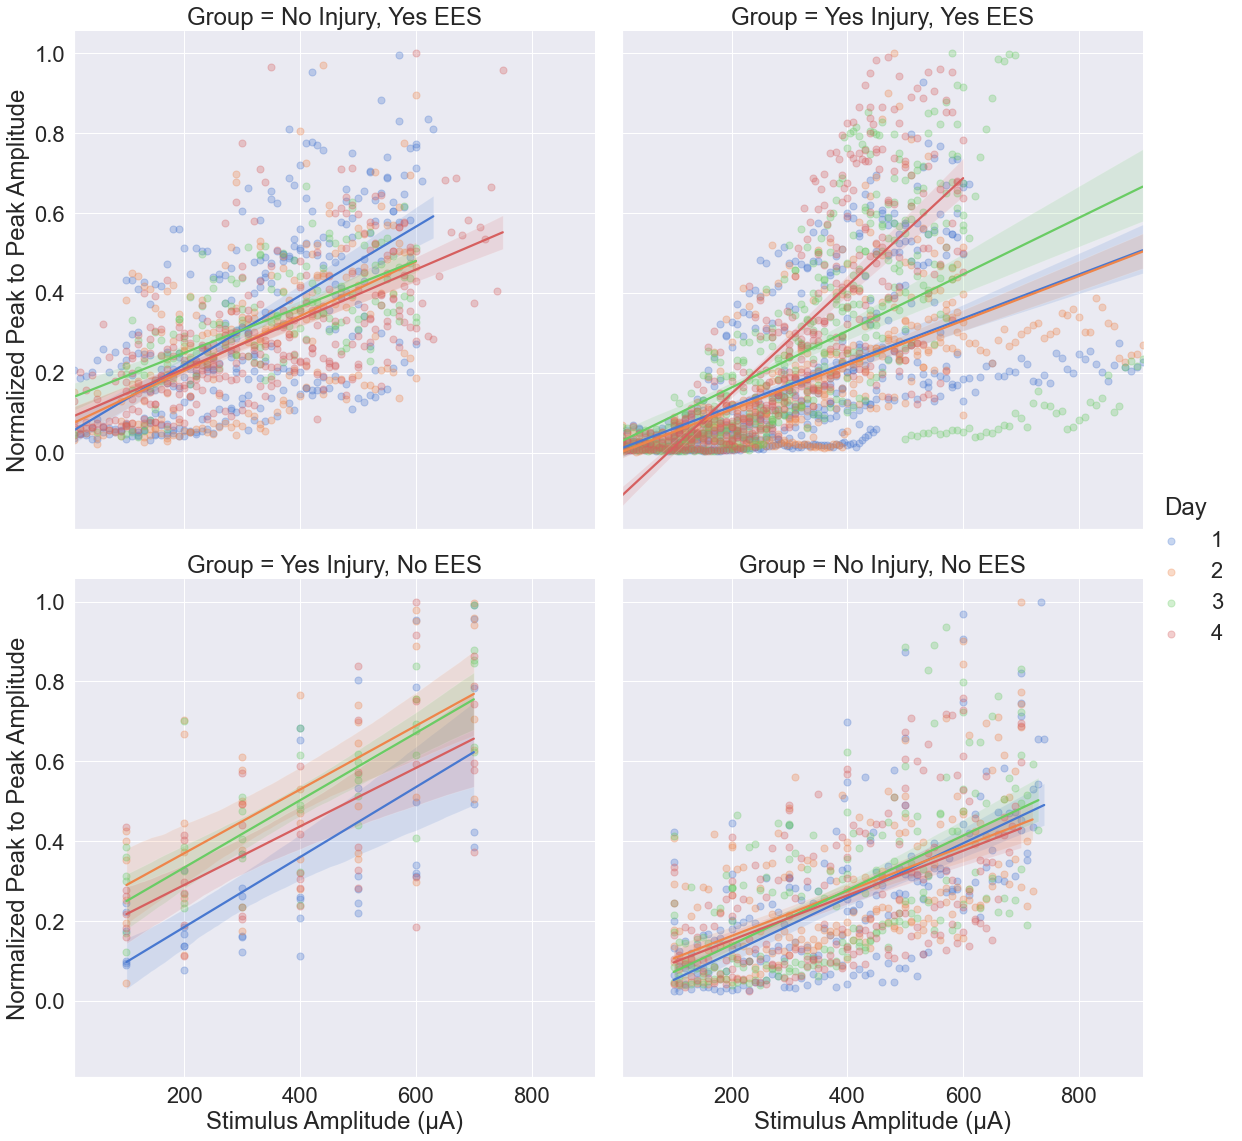

In [238]:
plt.figure(figsize=(24,12))
sns.set(font_scale=2)
sns.set_style("darkgrid")
sns.despine()
df_nice_plot = df_p2p_scaled.copy()
df_nice_plot = df_nice_plot.rename(columns={"Day_Stim": "Day", "p2p_amplitude_scaled": "Normalized Peak to Peak Amplitude", 
                                                    "Stim_Amplitude": "Stimulus Amplitude (μA)"})
ax = sns.lmplot(x="Stimulus Amplitude (μA)", y="Normalized Peak to Peak Amplitude", col="Group", hue="Day", data=df_nice_plot,
           col_wrap=2, order=1, ci=95, palette="muted", height=8,
           scatter_kws={"s": 50, "alpha": 0.3})
ax.savefig("D:\\groupmainfig.png")

<Figure size 1440x864 with 0 Axes>

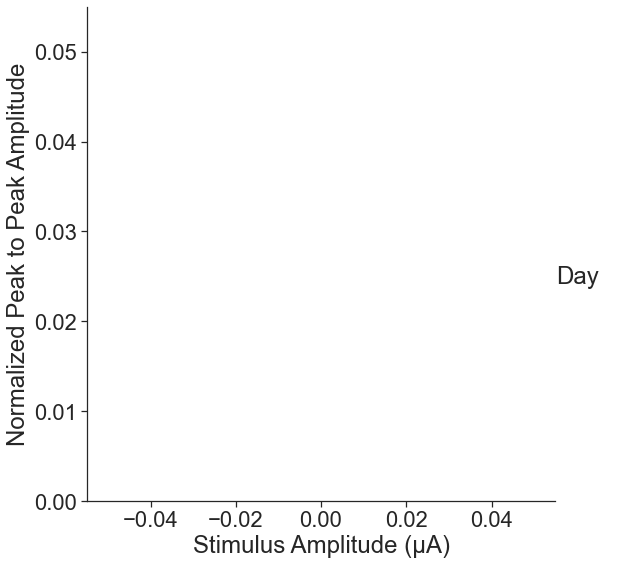

In [240]:
plt.figure(figsize=(20,12))
sns.set(font_scale=2)
sns.set_style("ticks")
sns.despine()
df_nice_plot = df_p2p_scaled.copy()
df_nice_plot = df_nice_plot.rename(columns={"Day_Stim": "Day", "p2p_amplitude_scaled": "Normalized Peak to Peak Amplitude", 
                                                    "Stim_Amplitude": "Stimulus Amplitude (μA)"})
ax = sns.lmplot(x="Stimulus Amplitude (μA)", y="Normalized Peak to Peak Amplitude", hue="Day", data=df_nice_plot[df_nice_plot['Group']=='Yes Injury, Yes Therapy'],
           order=1, ci=95, palette="tab10", height=8,
           scatter_kws={"s": 50, "alpha": 0.3})
ax.set(ylim=(0, None))
ax.savefig("D:\\t32-data-blitz.png")


plt.figure(figsize=(24,12))
sns.set(font_scale=2)
sns.set_style("darkgrid")
sns.despine()
df_nice_plot = df_p2p_scaled.copy()
df_nice_plot = df_nice_plot.rename(columns={"Day_Stim": "Day", "p2p_amplitude_scaled": "Normalized Peak to Peak Amplitude", 
                                                    "Stim_Amplitude": "Stimulus Amplitude (μA)"})
ax = sns.lmplot(x="Stimulus Amplitude (μA)", y="Normalized Peak to Peak Amplitude", col="Group", hue="Day", data=df_nice_plot,
           col_wrap=2, order=1, ci=95, palette="muted", height=8,
           scatter_kws={"s": 50, "alpha": 0.3})
ax.savefig("D:\\groupmainfig.png")

<Figure size 1728x864 with 0 Axes>

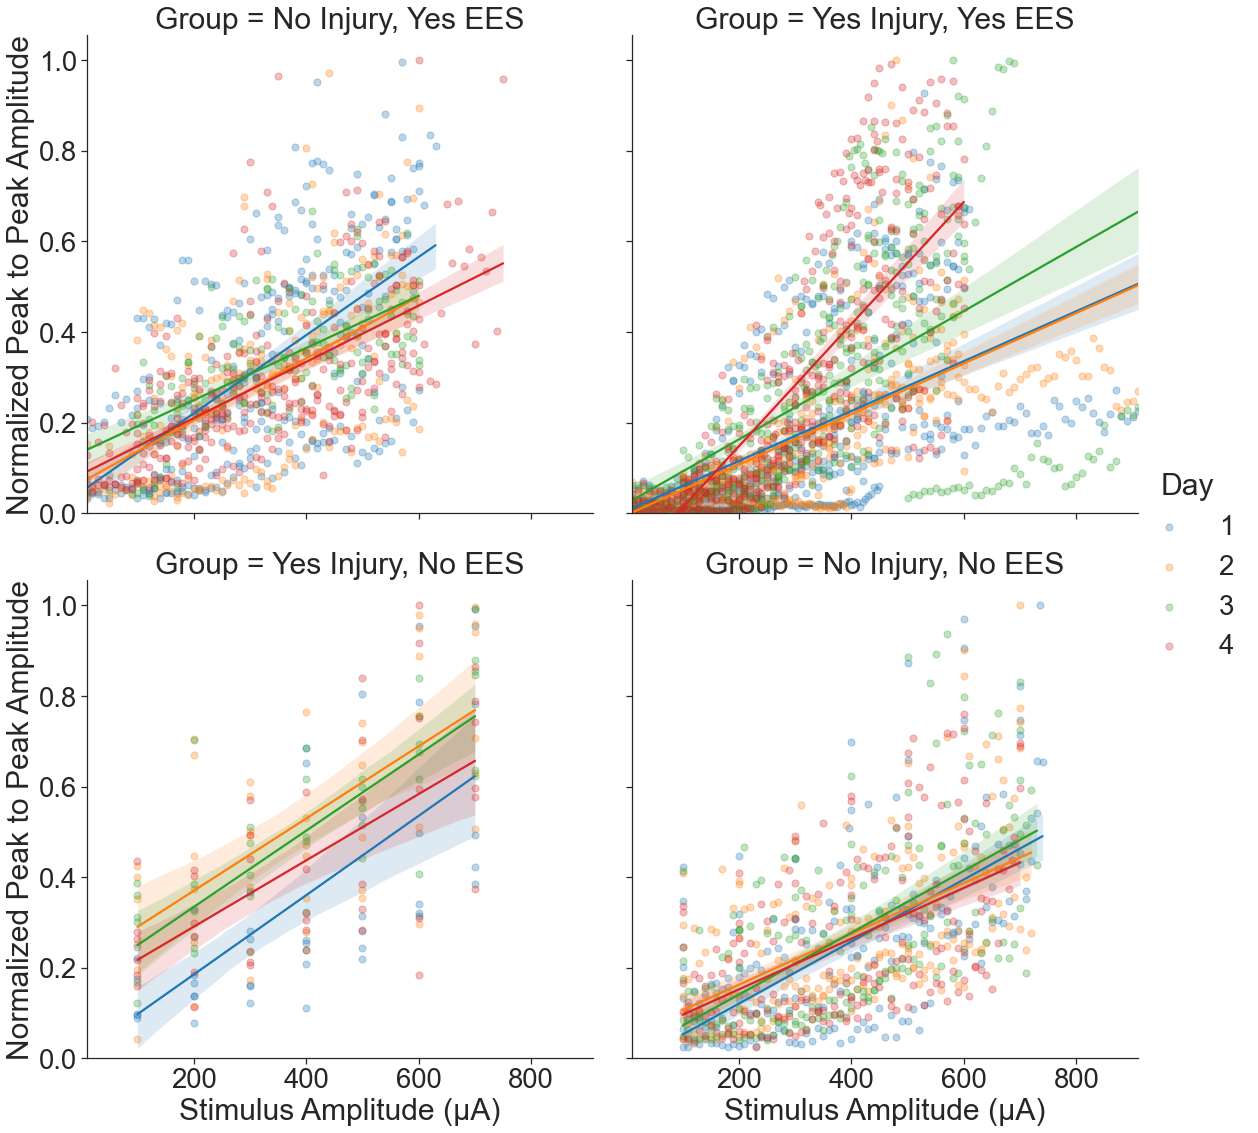

In [241]:
plt.figure(figsize=(24,12))
sns.set(font_scale=2.5)
sns.set_style("ticks")
sns.despine()

df_nice_plot = df_p2p_scaled.copy()
df_nice_plot = df_nice_plot.rename(columns={"Day_Stim": "Day", "p2p_amplitude_scaled": "Normalized Peak to Peak Amplitude", 
                                                    "Stim_Amplitude": "Stimulus Amplitude (μA)"})
ax = sns.lmplot(x="Stimulus Amplitude (μA)", y="Normalized Peak to Peak Amplitude", col="Group", hue="Day", data=df_nice_plot,
           col_wrap=2, order=1, ci=95, palette="tab10", height=8,
           scatter_kws={"s": 50, "alpha": 0.3})
ax.set(ylim=(0, None))
ax.savefig("D:\\t32-data-blitz.png")


#### Exploration of # hours before stim variable

In [28]:
# add column of # hours before stim for each animal
recent_animals = ['N27','N28','N29','N30','N31','N32','N33']

# set 0 as default for all animals
df_p2p_scaled["Hours_Stim"] = 0

# recent animals got 12h stim before MEPs after baseline day
df_p2p_scaled.loc[(df_p2p_scaled['Animal'].isin(recent_animals)) & (df_p2p_scaled['Day_Stim'] > 1), 'Hours_Stim'] = 12

# N01
df_p2p_scaled.loc[(df_p2p_scaled['Animal'] == 'N01') & (df_p2p_scaled['Day_Stim'] == 2), 'Hours_Stim'] = 5
df_p2p_scaled.loc[(df_p2p_scaled['Animal'] == 'N01') & (df_p2p_scaled['Day_Stim'] == 3), 'Hours_Stim'] = 7
df_p2p_scaled.loc[(df_p2p_scaled['Animal'] == 'N01') & (df_p2p_scaled['Day_Stim'] == 4), 'Hours_Stim'] = 23

# N04
df_p2p_scaled.loc[(df_p2p_scaled['Animal'] == 'N04') & (df_p2p_scaled['Day_Stim'] == 2), 'Hours_Stim'] = 7
df_p2p_scaled.loc[(df_p2p_scaled['Animal'] == 'N04') & (df_p2p_scaled['Day_Stim'] == 3), 'Hours_Stim'] = 23
df_p2p_scaled.loc[(df_p2p_scaled['Animal'] == 'N04') & (df_p2p_scaled['Day_Stim'] == 4), 'Hours_Stim'] = 1.5

# N05
df_p2p_scaled.loc[(df_p2p_scaled['Animal'] == 'N05') & (df_p2p_scaled['Day_Stim'] == 2), 'Hours_Stim'] = 7
df_p2p_scaled.loc[(df_p2p_scaled['Animal'] == 'N05') & (df_p2p_scaled['Day_Stim'] == 3), 'Hours_Stim'] = 23
df_p2p_scaled.loc[(df_p2p_scaled['Animal'] == 'N05') & (df_p2p_scaled['Day_Stim'] == 4), 'Hours_Stim'] = 20

# N09
df_p2p_scaled.loc[(df_p2p_scaled['Animal'] == 'N09') & (df_p2p_scaled['Day_Stim'] == 2), 'Hours_Stim'] = 14
df_p2p_scaled.loc[(df_p2p_scaled['Animal'] == 'N09') & (df_p2p_scaled['Day_Stim'] == 3), 'Hours_Stim'] = 21
df_p2p_scaled.loc[(df_p2p_scaled['Animal'] == 'N09') & (df_p2p_scaled['Day_Stim'] == 4), 'Hours_Stim'] = 22

# N10
df_p2p_scaled.loc[(df_p2p_scaled['Animal'] == 'N10') & (df_p2p_scaled['Day_Stim'] == 2), 'Hours_Stim'] = 20
df_p2p_scaled.loc[(df_p2p_scaled['Animal'] == 'N10') & (df_p2p_scaled['Day_Stim'] == 3), 'Hours_Stim'] = 22
df_p2p_scaled.loc[(df_p2p_scaled['Animal'] == 'N10') & (df_p2p_scaled['Day_Stim'] == 4), 'Hours_Stim'] = 14

# N11
df_p2p_scaled.loc[(df_p2p_scaled['Animal'] == 'N11') & (df_p2p_scaled['Day_Stim'] == 2), 'Hours_Stim'] = 21
df_p2p_scaled.loc[(df_p2p_scaled['Animal'] == 'N11') & (df_p2p_scaled['Day_Stim'] == 3), 'Hours_Stim'] = 22
df_p2p_scaled.loc[(df_p2p_scaled['Animal'] == 'N11') & (df_p2p_scaled['Day_Stim'] == 4), 'Hours_Stim'] = 22

# N13
df_p2p_scaled.loc[(df_p2p_scaled['Animal'] == 'N13') & (df_p2p_scaled['Day_Stim'] == 2), 'Hours_Stim'] = 24
df_p2p_scaled.loc[(df_p2p_scaled['Animal'] == 'N13') & (df_p2p_scaled['Day_Stim'] == 3), 'Hours_Stim'] = 28
df_p2p_scaled.loc[(df_p2p_scaled['Animal'] == 'N13') & (df_p2p_scaled['Day_Stim'] == 4), 'Hours_Stim'] = 28

# N34
df_p2p_scaled.loc[(df_p2p_scaled['Animal'] == 'N34') & (df_p2p_scaled['Day_Stim'] == 2), 'Hours_Stim'] = 22
df_p2p_scaled.loc[(df_p2p_scaled['Animal'] == 'N34') & (df_p2p_scaled['Day_Stim'] == 3), 'Hours_Stim'] = 22
df_p2p_scaled.loc[(df_p2p_scaled['Animal'] == 'N34') & (df_p2p_scaled['Day_Stim'] == 4), 'Hours_Stim'] = 22




#### Compare day 1 and day 4 max p2p amplitude for each group

In [29]:
df_avg_p2p = df_p2p_scaled.copy()
df_avg_p2p = df_avg_p2p[df_avg_p2p['Day_Stim'].isin([1,4])]
df_avg_p2p = df_avg_p2p.drop(columns=['Stim_Amplitude', 'Hours_Stim'])
df_mean = df_avg_p2p.groupby(['Day_Stim', 'Animal', 'Group'])['p2p_amplitude_scaled'].agg('mean').reset_index()
df_mean.head()
#df_avg_p2p.to_csv('D:\\df_avg_p2p.csv')

,Day_Stim,Animal,Group,p2p_amplitude_scaled
0,1,N01,"No Injury, Yes Therapy",0.229818
1,1,N04,"No Injury, Yes Therapy",0.427179
2,1,N05,"No Injury, Yes Therapy",0.156386
3,1,N09,"Yes Injury, Yes Therapy",0.069317
4,1,N10,"Yes Injury, Yes Therapy",0.164354


<Figure size 1728x1728 with 0 Axes>

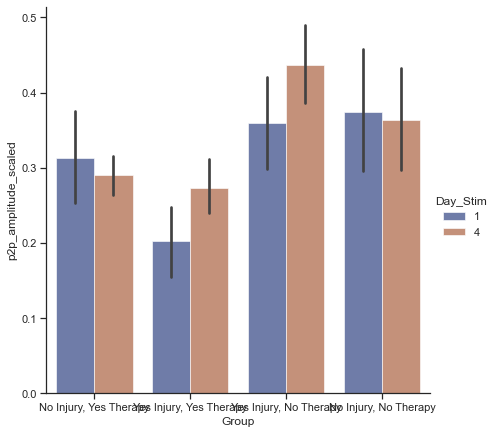

In [30]:
plt.figure(figsize=(24,24))
sns.set(font_scale=1)
sns.set_style("ticks")
sns.despine()

sns.catplot(
    data=df_mean, kind="bar",
    x="Group", y="p2p_amplitude_scaled", hue="Day_Stim",
    ci=68, palette="dark", alpha=.6, height=6
)

# sns.boxplot(x="Group", y="p2p_amplitude_scaled",
#             hue="Day_Stim",
#             data=df_avg_p2p)

#### Day 1 to day 4 percent change in max and mean p2p

In [165]:
df_d1d4_pchange = df_p2p_scaled.copy()
df_d1d4_pchange = df_d1d4_pchange[(df_d1d4_pchange['Day_Stim'].isin([1,4])) & (df_d1d4_pchange['Stim_Amplitude'].between(300,500))]

df_d1d4_pchange = df_d1d4_pchange.groupby(['Group', 'Day_Stim', 'Animal'])['p2p_amplitude_scaled'].agg('median').reset_index()
df_d1d4_pchange = df_d1d4_pchange.pivot(index=['Animal','Group'], columns='Day_Stim', values='p2p_amplitude_scaled').reset_index()
df_d1d4_pchange = df_d1d4_pchange.rename(columns={1: 'one', 4: 'four'})
df_d1d4_pchange['d1d4_pchange'] = ((df_d1d4_pchange['four'].sub(df_d1d4_pchange['one'])).div(df_d1d4_pchange["one"])).mul(100)
df_d1d4_pchange = df_d1d4_pchange.drop(columns=['one', 'four'])
df_d1d4_pchange.to_csv('D:\\df_d1d4_pchange.csv')

#### Threshold
At what amplitude did the animal hit 50% of its all time max?

In [166]:
df_p2p_scaled.head()

,Animal,Day_Stim,Stim_Amplitude,p2p_amplitude_scaled,Group,Hours_Stim
0,N01,1,10.0,0.044218,"No Injury, Yes Therapy",0.0
2,N01,1,20.0,0.045537,"No Injury, Yes Therapy",0.0
4,N01,1,30.0,0.047929,"No Injury, Yes Therapy",0.0
6,N01,1,40.0,0.061401,"No Injury, Yes Therapy",0.0
8,N01,1,50.0,0.084987,"No Injury, Yes Therapy",0.0


In [205]:
# df_p2p_scaled.groupby(['Animal', 'Day']).p2p_amplitude_scaled.agg('max')

# df_p2p_scaled.loc[df_p2p_scaled['p2p_amplitude_scaled']>0.5]['Stim_Amplitude'].min()

df_threshold = df_p2p_scaled.copy()
df_threshold = df_threshold[(df_threshold['Day_Stim'].isin([1,4]))]
df_threshold = df_threshold.pivot(index=['Animal','Group','Stim_Amplitude'], columns='Day_Stim', values='p2p_amplitude_scaled').reset_index()
df_threshold = df_threshold.rename(columns={1: 'one', 4: 'four'})
df_threshold['min_stim_1'] = df_threshold['Stim_Amplitude'].where(df_threshold['one'] > 0.25).groupby(df_threshold['Animal']).transform('min')
df_threshold['min_stim_4'] = df_threshold['Stim_Amplitude'].where(df_threshold['four'] > 0.25).groupby(df_threshold['Animal']).transform('min')
df_threshold = df_threshold.drop(columns=['one','four','Stim_Amplitude'])
df_threshold = df_threshold.rename_axis(None, axis=1)
df_threshold = df_threshold.drop_duplicates()

df_threshold.head(50)

,Animal,Group,min_stim_1,min_stim_4
0,N01,"No Injury, Yes Therapy",230.0,210.0
41,N04,"No Injury, Yes Therapy",60.0,60.0
116,N05,"No Injury, Yes Therapy",350.0,380.0
176,N09,"Yes Injury, Yes Therapy",NaN,160.0
225,N10,"Yes Injury, Yes Therapy",450.0,400.0
316,N11,"Yes Injury, Yes Therapy",180.0,250.0
376,N13,"Yes Injury, Yes Therapy",NaN,295.0
466,N14,"Yes Injury, No Therapy",200.0,100.0
473,N15,"Yes Injury, No Therapy",400.0,500.0
480,N16,"Yes Injury, No Therapy",300.0,100.0


In [ ]:
sns.catplot(
    data=df_threshold, kind="bar",
    x="Group", y="p2p_amplitude_scaled", hue="Day_Stim",
    ci=68, palette="dark", alpha=.6, height=6
)

#### Check linearity assumption with residual plot

In [33]:
# for all 4 groups and all 4 days, make stim vs p2p plot to check linearity

# multivariate normal. histogram or a Q-Q-Plot. Kolmogorov-Smirnov test.  
# When the data is not normally distributed a non-linear transformation (e.g., log-transformation) might fix this issue.

#### Updated plots for Otto meeting 3/17

In [34]:
df_p2p_scaled = df_p2p_scaled.dropna()

                             OLS Regression Results                             
Dep. Variable:     p2p_amplitude_scaled   R-squared:                       0.602
Model:                              OLS   Adj. R-squared:                  0.594
Method:                   Least Squares   F-statistic:                     74.12
Date:                  Wed, 17 Mar 2021   Prob (F-statistic):           2.27e-11
Time:                          14:53:13   Log-Likelihood:                 30.355
No. Observations:                    51   AIC:                            -56.71
Df Residuals:                        49   BIC:                            -52.85
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.181

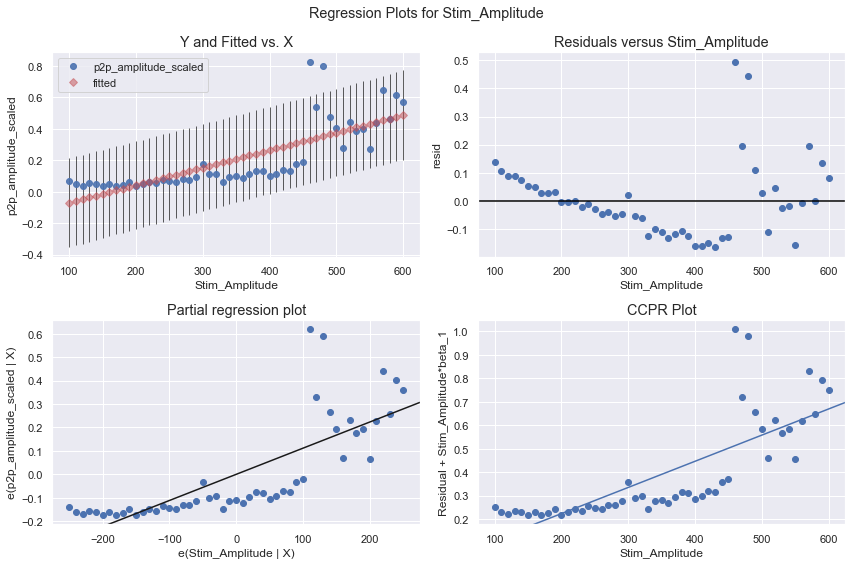

In [35]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

sns.set(font_scale=1)

model = ols('p2p_amplitude_scaled ~ Stim_Amplitude', data=df_p2p_scaled[(df_p2p_scaled['Animal']=='N27') & (df_p2p_scaled['Day_Stim']==3)]).fit()
print(model.summary())

fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(model, 'Stim_Amplitude', fig=fig)

In [36]:
# # fig = plt.figure(figsize=(12,8))
# # sns.set(font_scale=1)
# # r2 = np.asarray([])

# for animal in df_p2p_scaled.Animal.unique():
#     for day in df_p2p_scaled[df_p2p_scaled['Animal']==animal].Day_Stim.unique():
#         model = ols('p2p_amplitude_scaled ~ Stim_Amplitude', data=df_p2p_scaled[(df_p2p_scaled['Animal']==animal) & (df_p2p_scaled['Day_Stim']==day)]).fit()
# #         model = ols('p2p_amplitude_scaled ~ Stim_Amplitude', data=df_p2p_scaled[(df_p2p_scaled['Animal']==animal)]).fit()

# #         print(model.summary())

# #         fig = plt.figure(figsize=(12,8))
# #         fig = sm.graphics.plot_regress_exog(model, 'Stim_Amplitude', fig=fig)
# #         r2 = np.append(r2, model.rsquared)
#         print('Animal: ' + animal + '. Day: ' + str(day) + '. R^2: ' + str(model.rsquared))

        
        
        
# # #view model summary
# # print(model.summary())
# #         model.rsquared
# #         np.sum(model.resid)
# # #fit simple linear regression model
# # model = ols('p2p_amplitude_scaled ~ Stim_Amplitude', data=df_p2p_scaled[(df_p2p_scaled['Animal']=='N01') & (df_p2p_scaled['Day_Stim']==1)]).fit()


#### Export dataframe to csv for statistical modelling in R

In [37]:
df_p2p_scaled.to_csv('D:\\df_p2p_scaled.csv')

In [38]:
df_p2p_scaled.Animal.unique()

array(['N01', 'N04', 'N05', 'N09', 'N10', 'N11', 'N13', 'N14', 'N15',
       'N16', 'N17', 'N19', 'N20', 'N21', 'N22', 'N23', 'N24', 'N25',
       'N26', 'N27', 'N28', 'N30', 'N31', 'N32', 'N33', 'N34'],
      dtype=object)

In [39]:
df_p2p_scaled.groupby('Animal')['Day_Stim'].unique()

Animal
N01    [1, 2, 3, 4]
N04       [1, 2, 4]
N05       [1, 2, 4]
N09    [1, 2, 3, 4]
N10    [1, 2, 3, 4]
N11    [1, 2, 3, 4]
N13    [1, 2, 3, 4]
N14    [1, 2, 3, 4]
N15    [1, 2, 3, 4]
N16    [1, 2, 3, 4]
N17    [1, 2, 3, 4]
N19    [1, 2, 3, 4]
N20    [1, 2, 3, 4]
N21    [1, 2, 3, 4]
N22    [1, 2, 3, 4]
N23    [1, 2, 3, 4]
N24    [1, 2, 3, 4]
N25    [1, 2, 3, 4]
N26    [1, 2, 3, 4]
N27    [1, 2, 3, 4]
N28    [1, 2, 3, 4]
N30    [1, 2, 3, 4]
N31    [1, 2, 3, 4]
N32    [1, 2, 3, 4]
N33    [1, 2, 3, 4]
N34    [1, 2, 3, 4]
Name: Day_Stim, dtype: object

In [40]:
# df_p2p_scaled.tails(10)

In [41]:
df_p2p_scaled.groupby(['Animal'])['Hours_Stim'].unique()

Animal
N01      [0.0, 5.0, 7.0, 23.0]
N04            [0.0, 7.0, 1.5]
N05           [0.0, 7.0, 20.0]
N09    [0.0, 14.0, 21.0, 22.0]
N10    [0.0, 20.0, 22.0, 14.0]
N11          [0.0, 21.0, 22.0]
N13          [0.0, 24.0, 28.0]
N14                      [0.0]
N15                      [0.0]
N16                      [0.0]
N17                      [0.0]
N19                      [0.0]
N20                      [0.0]
N21                      [0.0]
N22                      [0.0]
N23                      [0.0]
N24                      [0.0]
N25                      [0.0]
N26                      [0.0]
N27                [0.0, 12.0]
N28                [0.0, 12.0]
N30                [0.0, 12.0]
N31                [0.0, 12.0]
N32                [0.0, 12.0]
N33                [0.0, 12.0]
N34                [0.0, 22.0]
Name: Hours_Stim, dtype: object

<Figure size 1440x1440 with 0 Axes>

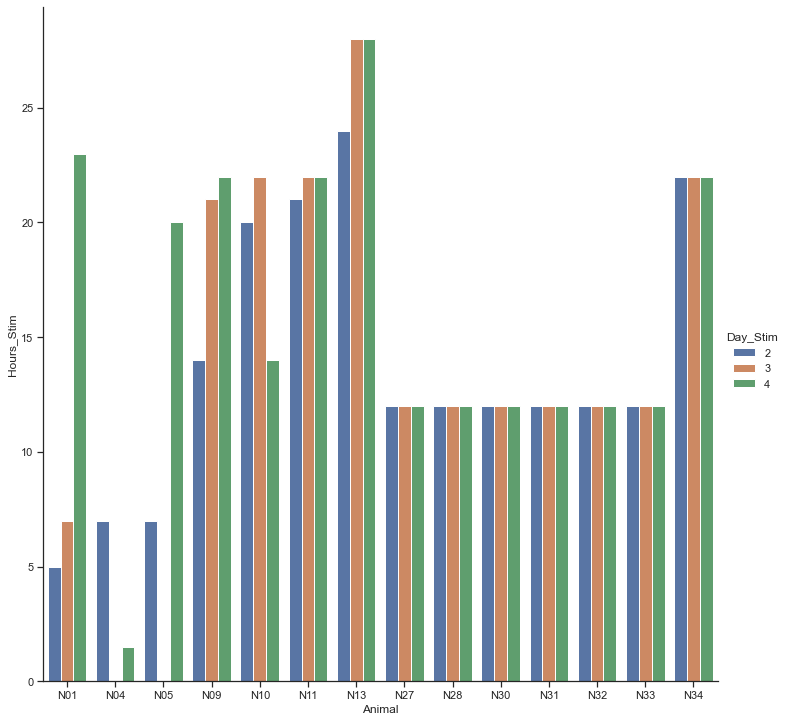

In [42]:
plt.figure(figsize=(20,20))
sns.set(font_scale=1)
sns.set_style("ticks")

sns.catplot(
    data=df_p2p_scaled[df_p2p_scaled['Hours_Stim']>0], kind="bar",
    x="Animal", y="Hours_Stim", hue="Day_Stim",
    ci="sd", height=10
)

In [43]:
df_hours_plot = df_p2p_scaled.copy()

def custom_round(x, base):
    return int(base * round(float(x)/base))

df_hours_plot['Stim_Amplitude'] = df_hours_plot['Stim_Amplitude'].apply(lambda x: custom_round(x, base=50))

df_hours_plot['Stim_Amplitude'].unique()

array([  0,  50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600,
       650, 700, 750, 800, 850, 900], dtype=int64)

<Figure size 1440x1440 with 0 Axes>

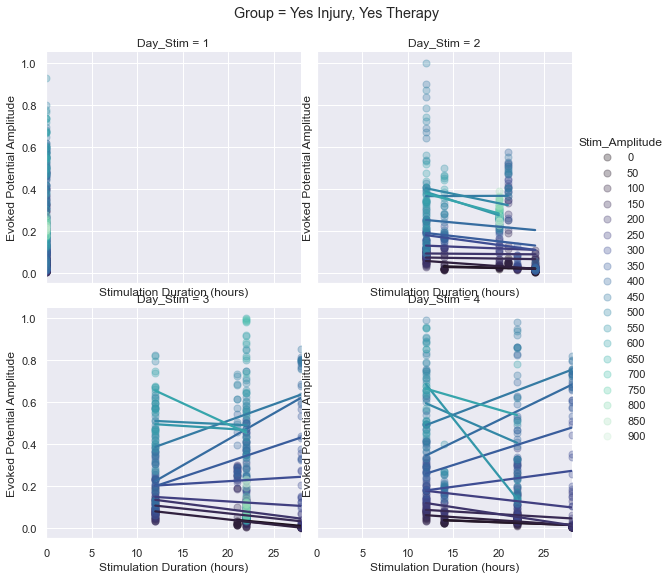

In [44]:
plt.figure(figsize=(20,20))
sns.set(font_scale=1)
sns.set_style("darkgrid")
rp = sns.lmplot(x="Hours_Stim", y="p2p_amplitude_scaled", col="Day_Stim", hue='Stim_Amplitude', data=df_hours_plot[(df_hours_plot['Group']=='Yes Injury, Yes Therapy')],
           col_wrap=2, palette="mako", height=4, ci=0,
           scatter_kws={"s": 50, "alpha": 0.3})

rp.fig.subplots_adjust(top=0.9)
rp.fig.suptitle('Group = Yes Injury, Yes Therapy')
rp.set(xlabel='Stimulation Duration (hours)', ylabel='Evoked Potential Amplitude')


<Figure size 1440x1440 with 0 Axes>

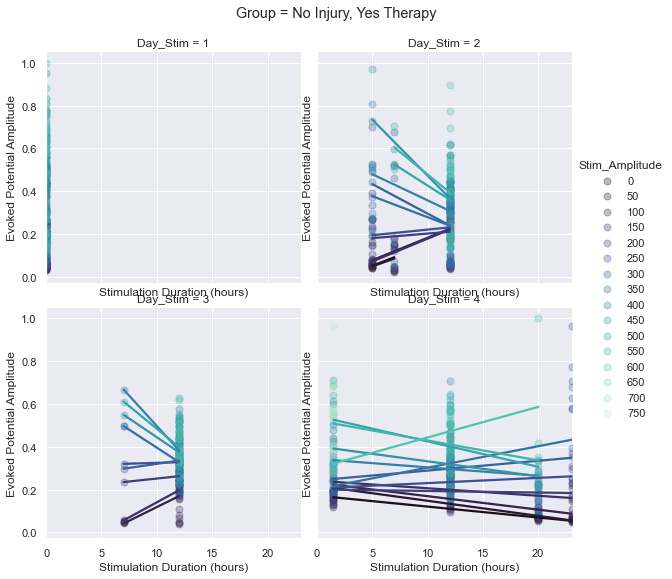

In [45]:
plt.figure(figsize=(20,20))
sns.set(font_scale=1)
sns.set_style("darkgrid")
rp = sns.lmplot(x="Hours_Stim", y="p2p_amplitude_scaled", col="Day_Stim", hue='Stim_Amplitude', data=df_hours_plot[(df_hours_plot['Group']=='No Injury, Yes Therapy')],
           col_wrap=2, palette="mako", height=4, ci=0,
           scatter_kws={"s": 50, "alpha": 0.3})

rp.fig.subplots_adjust(top=0.9)
rp.fig.suptitle('Group = No Injury, Yes Therapy')
rp.set(xlabel='Stimulation Duration (hours)', ylabel='Evoked Potential Amplitude')


In [46]:
df_p2p_scaled.head()

,Animal,Day_Stim,Stim_Amplitude,p2p_amplitude_scaled,Group,Hours_Stim
0,N01,1,10.0,0.044218,"No Injury, Yes Therapy",0.0
2,N01,1,20.0,0.045537,"No Injury, Yes Therapy",0.0
4,N01,1,30.0,0.047929,"No Injury, Yes Therapy",0.0
6,N01,1,40.0,0.061401,"No Injury, Yes Therapy",0.0
8,N01,1,50.0,0.084987,"No Injury, Yes Therapy",0.0


[Text(0.5, 1.0, 'No Injury, Yes Therapy')]

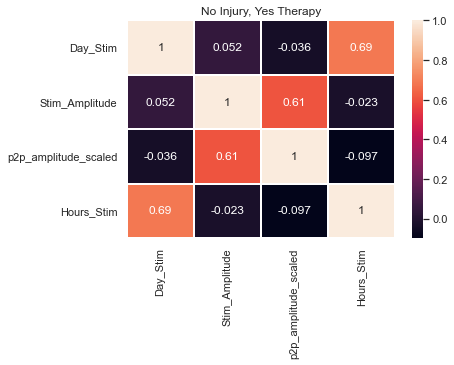

In [47]:
sns.heatmap(df_hours_plot[df_hours_plot['Group']=='No Injury, Yes Therapy'].corr(),annot=True,lw=1).set(title='No Injury, Yes Therapy')

[Text(0.5, 1.0, 'Yes Injury, Yes Therapy')]

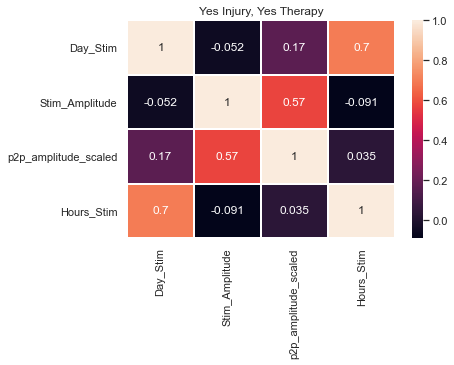

In [48]:
sns.heatmap(df_hours_plot[df_hours_plot['Group']=='Yes Injury, Yes Therapy'].corr(),annot=True,lw=1).set(title='Yes Injury, Yes Therapy')

<Figure size 2160x2160 with 0 Axes>

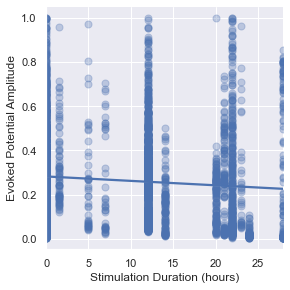

In [49]:
sns.set(font_scale=1)
sns.set_style("darkgrid")
plt.figure(figsize=(30,30))

ax = sns.lmplot(x="Hours_Stim", y="p2p_amplitude_scaled", data=df_hours_plot,
           palette="mako", height=4, ci=0,
           scatter_kws={"s": 50, "alpha": 0.3})
ax.set(xlabel='Stimulation Duration (hours)', ylabel='Evoked Potential Amplitude')

# rp.fig.subplots_adjust(top=0.9)
# rp.fig.suptitle('Group = No Injury, Yes Therapy')
# rp.set(xlabel='Stimulation Duration (hours)', ylabel='Evoked Potential Amplitude')
ax.savefig("D:\\all_vars.png")




In [50]:
X = df_hours_plot[['Hours_Stim']] 
y = df_hours_plot['p2p_amplitude_scaled']
X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     p2p_amplitude_scaled   R-squared:                       0.008
Model:                              OLS   Adj. R-squared:                  0.007
Method:                   Least Squares   F-statistic:                     29.38
Date:                  Wed, 17 Mar 2021   Prob (F-statistic):           6.32e-08
Time:                          14:53:27   Log-Likelihood:                 418.97
No. Observations:                  3876   AIC:                            -833.9
Df Residuals:                      3874   BIC:                            -821.4
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2817      0.005     58.716      0.000       0.272       0.291
Hours_Stim    -0.0020      0.000     -5.420      0.000      -0.003      -0.001
==============================================================================
Omnibus:                      521.672   Durbin-Watson:                   0.327
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              750.785
Skew:                           1.039   Prob(JB):                    9.31e-164
Kurtosis:                       3.578   Cond. No.                         17.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [51]:
X = df_hours_plot[['Day_Stim', 'Stim_Amplitude', 'Group', 'Hours_Stim']] 
y = df_hours_plot['p2p_amplitude_scaled']
X = pd.get_dummies(data=X, drop_first=True)
X.head()

,Day_Stim,Stim_Amplitude,Hours_Stim,"Group_No Injury, Yes Therapy","Group_Yes Injury, No Therapy","Group_Yes Injury, Yes Therapy"
0,1,0,0.0,1,0,0
2,1,0,0.0,1,0,0
4,1,50,0.0,1,0,0
6,1,50,0.0,1,0,0
8,1,50,0.0,1,0,0


In [52]:
# X = df_hours_plot[['Day_Stim', 'Stim_Amplitude', 'Group', 'Hours_Stim']] 
# y = df_hours_plot['p2p_amplitude_scaled']
## fit a OLS model with intercept on TV and Radio
X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     p2p_amplitude_scaled   R-squared:                       0.391
Model:                              OLS   Adj. R-squared:                  0.390
Method:                   Least Squares   F-statistic:                     414.1
Date:                  Wed, 17 Mar 2021   Prob (F-statistic):               0.00
Time:                          14:53:27   Log-Likelihood:                 1365.6
No. Observations:                  3876   AIC:                            -2717.
Df Residuals:                      3869   BIC:                            -2673.
Df Model:                             6                                         
Covariance Type:              nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                            -0.0568      0.011     -5.061      0.000      -0.079      -0.035
Day_Stim                          0.0195      0.003      6.525      0.000       0.014       0.025
Stim_Amplitude                    0.0007   1.53e-05     45.287      0.000       0.001       0.001
Hours_Stim                       -0.0006      0.000     -1.427      0.154      -0.002       0.000
Group_No Injury, Yes Therapy      0.0933      0.009     10.532      0.000       0.076       0.111
Group_Yes Injury, No Therapy      0.1880      0.014     13.000      0.000       0.160       0.216
Group_Yes Injury, Yes Therapy     0.0187      0.010      1.944      0.052      -0.000       0.038
==============================================================================
Omnibus:                      393.341   Durbin-Watson:                   0.345
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              562.688
Skew:                           0.786   Prob(JB):                    6.51e-123
Kurtosis:                       4.007   Cond. No.                     2.37e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.37e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [53]:
# import statsmodels.api as sm

# df_ols = df_p2p_ratio_max[(df_p2p_ratio_max['Group']=='Yes Injury, Yes Stimulation') & (df_p2p_ratio_max['Day_Stim']==2)]

# X=df_ols['Hours_Stim']
# Y=df_ols['p2p_ratio_max']
# X = sm.add_constant(X) # add intercept

# model = sm.OLS(Y, X).fit()
# predictions = model.predict(X) 

# print_model = model.summary()
# print(print_model)

In [54]:
# sns.lmplot(x="Stim_Amplitude", y="p2p_ratio_max", col="Day_Stim", data=df_p2p_ratio_max[(df_p2p_ratio_max['Group']=='Yes Injury, Yes Stimulation')],
#            col_wrap=2, ci=95, palette="muted", height=4,
#            scatter_kws={"s": 50, "alpha": 0.3})

In [55]:
# df_ols = df_p2p_ratio_max[(df_p2p_ratio_max['Group']=='Yes Injury, Yes Stimulation') & (df_p2p_ratio_max['Day_Stim']==4)]

# X=df_ols['Stim_Amplitude']
# Y=df_ols['p2p_ratio_max']
# X = sm.add_constant(X) # add intercept

# model = sm.OLS(Y, X).fit()
# predictions = model.predict(X) 

# print_model = model.summary()
# print(print_model)


In [56]:
# sns.lmplot(x="Hours_Stim", y="p2p_ratio_max", col="Day_Stim", data=df_p2p_ratio_max[df_p2p_ratio_max['Group']=='No Injury, Yes Stimulation'],
#            col_wrap=2, ci=95, palette="muted", height=4,
#            scatter_kws={"s": 50, "alpha": 0.3})

In [57]:
# sns.set(font_scale=1)
# stim_amps = [100, 150, 200, 250, 300, 350, 400, 450, 500, 550]

# sns.lmplot(x="Hours_Stim", y="p2p_ratio_max", col="Stim_Amplitude", data=df_p2p_ratio_max[(df_p2p_ratio_max['Group']=='No Injury, Yes Stimulation') & (df_p2p_ratio_max['Stim_Amplitude'].isin(stim_amps))],
#            col_wrap=2, ci=95, palette="muted", height=4,
#            scatter_kws={"s": 50, "alpha": 0.3})

In [58]:
# df_ols = df_p2p_ratio_max[(df_p2p_ratio_max['Group']=='No Injury, Yes Stimulation') & (df_p2p_ratio_max['Day_Stim']==4)]

# X=df_ols['Hours_Stim']
# Y=df_ols['p2p_ratio_max']
# X = sm.add_constant(X) # add intercept

# model = sm.OLS(Y, X).fit()
# predictions = model.predict(X) 

# print_model = model.summary()
# print(print_model)

In [59]:
# df_p2p_ratio_max.head()

In [60]:
# stim_amp_list = [200, 250, 300, 350, 400, 450, 500, 600]

# sns.set(font_scale=1)
# sns.set_style("ticks")
# sns.despine()
# plt.figure(figsize=(20,12))

# plt.figure(figsize=(20,20))
# sns.set_style("ticks")
# g = sns.FacetGrid(df_p2p_ratio_max[df_p2p_ratio_max['Stim_Amplitude'].isin(stim_amp_list)], col="Group")
# g = (g.map(sns.scatterplot, "Stim_Amplitude", "p2p_ratio_max", 'Day_Stim').add_legend())

In [61]:
# sns.lmplot(x="Stim_Amplitude", y="p2p_ratio_max", col="Group", hue="Day_Stim", data=df_p2p_ratio_max,
#            col_wrap=2, ci=95, palette="muted", height=4,
#            scatter_kws={"s": 50, "alpha": 0.1})

#### Look at p2p for each animal and each side

In [62]:
# g = sns.FacetGrid(df_p2p_ratio_max, col='Side', row='Animal', hue='Day_Stim')
# g.map_dataframe(sns.scatterplot, x='Stim_Amplitude', y='p2p_ratio_max')
# g.add_legend()

## Feature exploration and importance for peak-to-peak amplitude


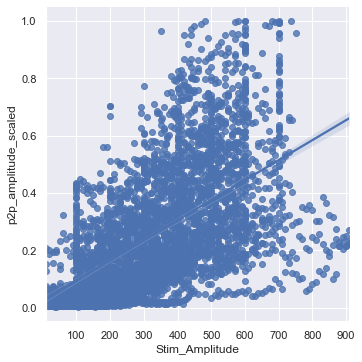

In [63]:
sns.lmplot(data=df_p2p_scaled, x="Stim_Amplitude", y="p2p_amplitude_scaled")

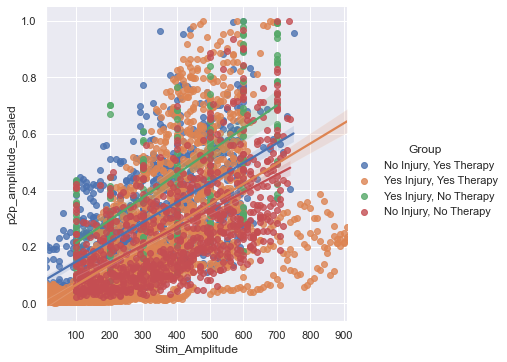

In [64]:
sns.lmplot(data=df_p2p_scaled, x="Stim_Amplitude", y="p2p_amplitude_scaled", hue="Group")

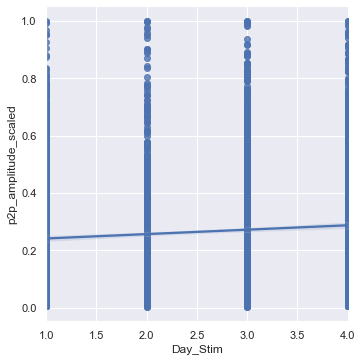

In [65]:
sns.lmplot(data=df_p2p_scaled, x="Day_Stim", y="p2p_amplitude_scaled")

<AxesSubplot:xlabel='Day_Stim', ylabel='p2p_amplitude_scaled'>

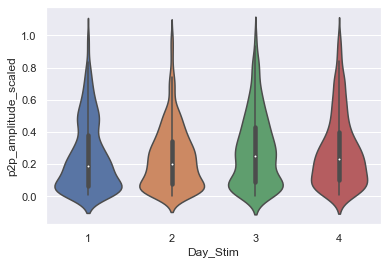

In [66]:
sns.violinplot(data=df_p2p_scaled, x="Day_Stim", y="p2p_amplitude_scaled")

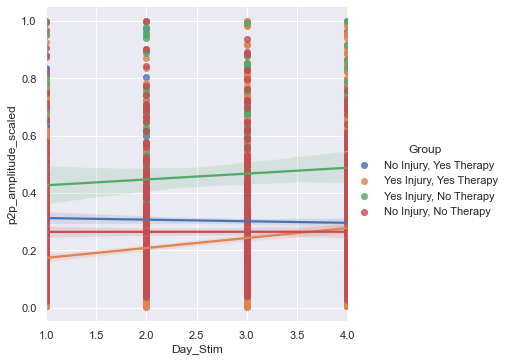

In [67]:
sns.lmplot(data=df_p2p_scaled, x="Day_Stim", y="p2p_amplitude_scaled", hue="Group")

<AxesSubplot:xlabel='Day_Stim', ylabel='p2p_amplitude_scaled'>

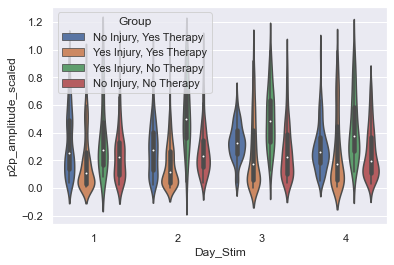

In [68]:
sns.violinplot(data=df_p2p_scaled, x="Day_Stim", y="p2p_amplitude_scaled", hue="Group")

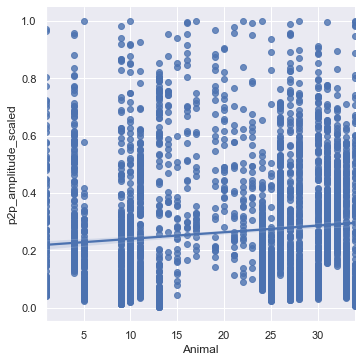

In [69]:
# is there a systematic difference across data of data collection?
# ie. are earlier animals difference than later animals

df_animalnumber = df_p2p_scaled.copy()
df_animalnumber['Animal'] = df_animalnumber['Animal'].str[1:].astype('int64')
sns.lmplot(data=df_animalnumber, x="Animal", y="p2p_amplitude_scaled")

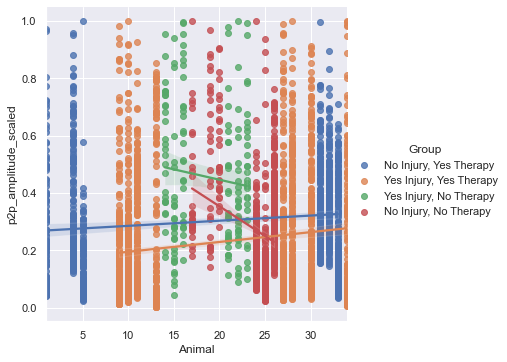

In [70]:
sns.lmplot(data=df_animalnumber, x="Animal", y="p2p_amplitude_scaled", hue="Group")

In [71]:
# df_p2p_ratio_max.head()

In [72]:
# df_kbest = df_animalnumber.copy()
# df_kbest = df_kbest.drop(columns=['Side'])

# # from sklearn.feature_selection import SelectKBest
# # from sklearn.feature_selection import chi2
# # X = df_kbest.iloc[:,[0,1,2,4]]  #independent columns
# # y = df_kbest.iloc[:,3]    #target column i.e price range
# # #apply SelectKBest class to extract top 10 best features
# # bestfeatures = SelectKBest(score_func=chi2, k=10)
# # fit = bestfeatures.fit(X,y)
# # dfscores = pd.DataFrame(fit.scores_)
# # dfcolumns = pd.DataFrame(X.columns)
# # #concat two dataframes for better visualization 
# # featureScores = pd.concat([dfcolumns,dfscores],axis=1)
# # featureScores.columns = ['Specs','Score']  #naming the dataframe columns
# # print(featureScores.nlargest(10,'Score'))  #print 10 best features


# X = df_animalnumber.iloc[:,[0,1,2,3,5]]  #independent columns
# y = df_animalnumber.iloc[:,4]    #target column i.e price range
# from sklearn.ensemble import ExtraTreesClassifier
# import matplotlib.pyplot as plt
# model = ExtraTreesClassifier()
# model.fit(X,y)
# print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
# #plot graph of feature importances for better visualization
# feat_importances = pd.Series(model.feature_importances_, index=X.columns)
# feat_importances.nlargest(10).plot(kind='barh')
# plt.show()

## Peak-to-peak latency analysis (3.75 ms time bins)

In [73]:
# df_bin = df_sta_noart[df_sta_noart['Time'] <= 15].copy()
# df_bin['Bin'] = pd.cut(df_bin.Time, 
#                 bins=[0,3.75,7.5,11.25], 
#                 include_lowest=True, 
#                 labels=['0-3.75ms','3.75-7.5ms','7.5-11.25ms'])
# df_bin = df_bin.dropna()
# df_bin.head()

In [74]:
# df_p2p_latency = df_bin.copy()
# df_p2p_latency = df_p2p_latency.groupby(['Animal', 'Day_Stim', 'Stim_Amplitude', 'Bin'])['STA_Amplitude'].apply(lambda x: x.max() + abs(x.min())).reset_index().rename(columns={'STA_Amplitude':'p2p_amplitude'})
# df_p2p_latency.head()

In [75]:
# df_p2p_latency = df_p2p_latency.merge(df_p2p_latency.groupby(['Animal'])['p2p_amplitude'].max(), on='Animal', how='left')
# df_p2p_latency['p2p_ratio_max'] = df_p2p_latency['p2p_amplitude_x'] / df_p2p_latency['p2p_amplitude_y']
# df_p2p_latency = df_p2p_latency.drop(columns=['p2p_amplitude_x', 'p2p_amplitude_y'])
# df_p2p_latency.head()

In [76]:
# add_group(df_p2p_latency)
# df_p2p_latency.head()

In [77]:
# df_p2p_latency_mean = df_p2p_latency.groupby(['Group', 'Day_Stim', 'Stim_Amplitude', 'Bin'])['p2p_ratio_max'].agg('mean').reset_index().rename(columns={'p2p_ratio_max':'mean_p2p_ratio_max'}).copy()
# df_p2p_latency_mean.head()

In [78]:
# df_p2p_latency_mean['Day_Stim'].unique()

#### Plotting

In [79]:
# stimamps = [200, 220, 240, 260, 280, 300, 320, 340, 360, 380, 400]
# days = [1, 4]

# df_plot = df_p2p_latency_mean[df_p2p_latency_mean['Stim_Amplitude'].isin(stimamps) & df_p2p_latency['Day_Stim'].isin(days)].copy()
# df_plot = df_plot.rename(columns={"Bin": "Time Bin", "mean_p2p_ratio_max": "Mean Peak-to-Peak Amplitude (mV)", 'Day_Stim':'Day'})

In [80]:
# sns.set(font_scale=2)
# sns.set_style("ticks")
# g = sns.FacetGrid(df_plot, col="Group", size=6, palette='tab10')
# g = (g.map(sns.scatterplot, "Time Bin", "Mean Peak-to-Peak Amplitude (mV)", 'Day', s=75).add_legend())
# plt.savefig('D:\\test.png')

## Spike P2P

In [81]:
filename = 'ian_2021_02_18_MEP_reformatted'

project = 'NEIL' if 'NEIL' in filename else 'SPARC'
path = 'D:\\Dataframe_CSVs\\%s.csv' % filename

df_spike_p2p = pd.read_csv(path)

In [82]:
df_spike_p2p.head()

,animal,stim_amp,left_0_p2p,left_1_p2p,left_2_p2p,left_3_p2p,left_4_p2p,right_0_p2p,right_1_p2p,right_2_p2p,right_3_p2p,right_4_p2p
0,N34,100,0.058285,0.073897,0.021596,0.130937,0.085119,0.072823,0.216535,0.204672,0.256578,0.258001
1,N34,110,0.025594,0.150029,0.026110,0.080430,0.028070,0.092374,0.249334,0.232758,0.223908,0.182822
2,N34,120,0.038084,0.045427,0.037755,0.140675,0.114606,0.124031,0.240828,0.194209,0.344865,0.186777
3,N34,130,0.034803,0.149995,0.048413,0.382579,0.338746,0.147740,0.417845,0.198024,0.211190,0.091727
4,N34,140,0.089865,0.153758,0.395963,0.435916,0.319633,0.102643,0.193853,0.601254,0.330093,0.237811


In [83]:
df_spike_long = pd.melt(df_spike_p2p, id_vars=['animal', 'stim_amp'], value_vars=['left_0_p2p', 'left_1_p2p', 'left_2_p2p', 'left_3_p2p','left_4_p2p','right_0_p2p','right_1_p2p','right_2_p2p','right_3_p2p','right_4_p2p'])
df_spike_long[['side','day', 'metric']] = df_spike_long['variable'].str.split('_',expand=True)
df_spike_long = df_spike_long.drop(columns=['variable', 'metric'])
df_spike_long = df_spike_long.dropna()
df_spike_long = df_spike_long.astype({'day': 'int'})
df_spike_long.head()

,animal,stim_amp,value,side,day
0,N34,100,0.058285,left,0
1,N34,110,0.025594,left,0
2,N34,120,0.038084,left,0
3,N34,130,0.034803,left,0
4,N34,140,0.089865,left,0


<Figure size 432x288 with 0 Axes>

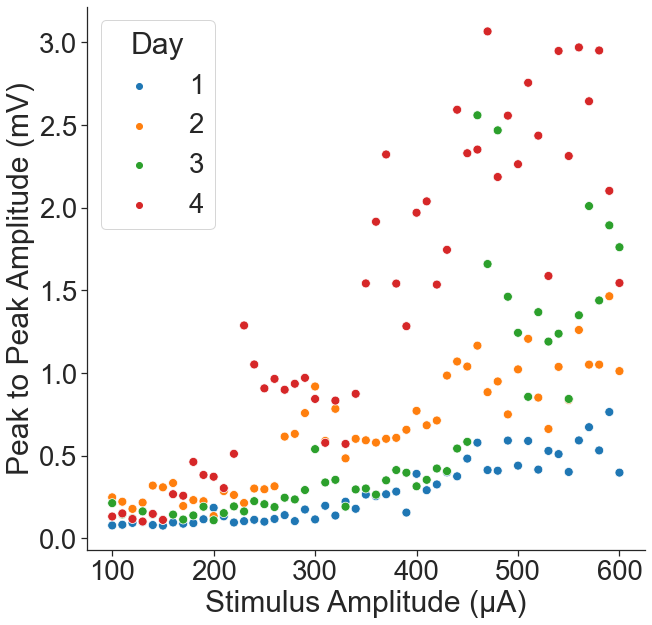

In [84]:
# Representative plot for presentations

sns.set(font_scale=2.5)
sns.set_style("ticks")
sns.despine()
plt.figure(figsize=(10,10))


ax = sns.scatterplot(data=df_p2p[(df_p2p['Animal']=='N27')], 
                x='Stim_Amplitude', y='p2p_amplitude', palette='tab10', hue='Day_Stim', s=80)
ax.set(xlabel='Stimulus Amplitude (μA)', ylabel='Peak to Peak Amplitude (mV)')
ax.legend().set_title('Day')
sns.despine()
ax.figure.savefig("D:\\N09_representative.png")

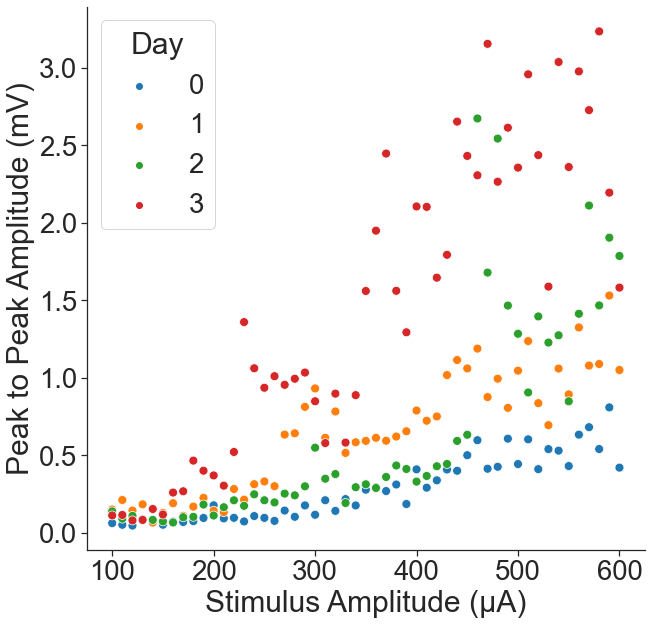

In [85]:
# Representative plot for presentations



plt.figure(figsize=(10,10))

ax = sns.scatterplot(data=df_spike_long[(df_spike_long['animal']=='N27') & (df_spike_long['day'] < 4) & (df_spike_long['side']=='left')], 
                x='stim_amp', y='value', palette='tab10', hue='day', s=80)
ax.set(xlabel='Stimulus Amplitude (μA)', ylabel='Peak to Peak Amplitude (mV)')
ax.legend().set_title('Day')
sns.despine()
#ax.figure.savefig("D:\\N09_representative.png")

In [86]:
df_spike_long.dtypes

animal       object
stim_amp      int64
value       float64
side         object
day           int32
dtype: object

In [87]:
df_spike_long.head()

,animal,stim_amp,value,side,day
0,N34,100,0.058285,left,0
1,N34,110,0.025594,left,0
2,N34,120,0.038084,left,0
3,N34,130,0.034803,left,0
4,N34,140,0.089865,left,0


## Area under the curve analysis

## Area under the curve latency analysis (3.75 ms time bins)

In [88]:
# df_auc_latency = df_bin.copy()

In [89]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# plt.figure(figsize=(20,20))
# sns.set_style("ticks")
# g = sns.FacetGrid(df_auc, col="Group")
# g = (g.map(sns.scatterplot, "Stim_Amplitude", "STA_AUC", 'Day_Stim').add_legend())

### Calculate statistics on the plotted lines above
##### slope, intercept, r_value, p_value, std_err

Make dataframes for each group. This will make it easier to subset in the next step.

In [90]:
# # group: no injury, no stimulation
# df_nn = df_ratio_max[df_ratio_max['Group'] == 'No Injury, No Stimulation']
# df_nn1 = df_nn[df_nn['Day_Stim'] == 1]
# df_nn2 = df_nn[df_nn['Day_Stim'] == 2]
# df_nn3 = df_nn[df_nn['Day_Stim'] == 3]
# df_nn4 = df_nn[df_nn['Day_Stim'] == 4]

# # group: no injury, yes stimulation
# df_ny = df_ratio_max[df_ratio_max['Group'] == 'No Injury, Yes Stimulation']
# df_ny1 = df_ny[df_ny['Day_Stim'] == 1]
# df_ny2 = df_ny[df_ny['Day_Stim'] == 2]
# df_ny3 = df_ny[df_ny['Day_Stim'] == 3]
# df_ny4 = df_ny[df_ny['Day_Stim'] == 4]

# # group: yes injury, no stimulation
# df_yn = df_ratio_max[df_ratio_max['Group'] == 'Yes Injury, No Stimulation']
# df_yn1 = df_yn[df_yn['Day_Stim'] == 1]
# df_yn2 = df_yn[df_yn['Day_Stim'] == 2]
# df_yn3 = df_yn[df_yn['Day_Stim'] == 3]
# df_yn4 = df_yn[df_yn['Day_Stim'] == 4]

# # group: yes injury, yes stimulation
# df_yy = df_ratio_max[df_ratio_max['Group'] == 'Yes Injury, Yes Stimulation']
# df_yy1 = df_yy[df_yy['Day_Stim'] == 1]
# df_yy2 = df_yy[df_yy['Day_Stim'] == 2]
# df_yy3 = df_yy[df_yy['Day_Stim'] == 3]
# df_yy4 = df_yy[df_yy['Day_Stim'] == 4]

In [91]:
# from scipy import stats
# from sklearn.linear_model import LinearRegression
# import statsmodels.api as sm

# df = df_yy4

# X = df['Stim_Amplitude']
# y = df['p2p_ratio_max']

# X2 = sm.add_constant(X)
# est = sm.OLS(y, X2)
# est2 = est.fit()
# print(est2.summary())

### Apply linear mixed effects model (random slopes) to data plotted above

In [92]:
# df_ratio_max.head()

In [93]:
# import statsmodels.api as sm
# import statsmodels.formula.api as smf

# md = sm.MixedLM.from_formula("p2p_ratio_max ~ Stim_Amplitude + Day_Stim", df_ratio_max, groups=df_ratio_max["Group"])

# mdf = md.fit()

# print(mdf.summary())

### Calculate area under the stimulus triggered average curves 
##### For each current amplitude, each animal, and each day

In [94]:
#### KEEP THIS. MAY SPLIT INTO TIME BINS IN FUTURE

# bins = [0.001, 0.004, 0.007, 0.010, 0.013, 0.0298] # define bins
# labels = ['1 to 4 ms', '4 to 7 ms', '7 to 10 ms', '10 to 13 ms', '13 to 29.8 ms'] # define bin labels
# #labels = [1, 2, 3, 4, 5]

# df_bin = df_sta_sub_norm.copy()
# df_bin['Time_Bin'] = pd.cut(df_bin['Time'], bins, labels=labels, right=False) # add Time_Bin column to dataframe
# df_bin = df_bin.reindex(columns=['Animal', 'Day', 'Side', 'Stim_Amplitude', 'Time', 'Time_Bin', 'STA_Scaled'])
# df_bin.rename(columns = {'Time_Bin':'Bin'}, inplace = True) 
# df_bin = df_bin[df_bin['Bin'] != '13 to 29.8 ms'] # drop all data 13 ms after the stimulation
# df_bin.head()


# from scipy import integrate

# df_auc = df_bin.groupby(['Animal', 'Day', 'Side', 'Stim_Amplitude', 'Bin'])['STA_Scaled'].apply(integrate.simps).reset_index()
# df_auc.rename(columns = {'STA_Scaled':'STA_AUC'}, inplace = True)
# df_auc = df_auc.dropna()
# df_auc.head()

In [95]:
# df_noisefloor_auc = df_sta_noart.copy()
# df_noisefloor_auc = df_noisefloor_auc[(df_noisefloor_auc['Time'] > 20.0)]
# df_noisefloor_auc.head()

In [96]:
# df_auc = df_sta_noart.copy()
# df_auc = df_auc[(df_auc['Time'] > 2.0) & (df_auc['Time'] < 10.2)]
# df_auc.tail()

In [97]:
# import numpy as np
# # define animal groups
# injstim = ['N09','N10','N11','N13','N27','N28','N29','N30']
# noinjstim = ['N01','N04','N05','N31','N32','N33','N34','N35'] 
# injnostim = ['N14','N15','N16','N21','N22','N23','N36','N37']
# noinjnostim = ['N17','N19','N20','N24','N25','N26','N38','N39'] 

# # add animal group information to the dataframe
# conditions = [
#     (df_auc['Animal'].isin(injstim) ),
#     (df_auc['Animal'].isin(noinjstim) ),
#     (df_auc['Animal'].isin(injnostim) ),
#     (df_auc['Animal'].isin(noinjnostim) )]
# choices = ['Injury and Stimulation', 'No Injury and Stimulation', 'Injury and No Stimulation', 'No Injury and No Stimulation']
# df_auc['Group'] = np.select(conditions, choices)
# df_auc.head()

In [98]:
# df_noisefloor_peak = df_noisefloor_auc.copy()
# df_noisefloor_peak = df_noisefloor_peak.groupby(['Animal', 'Day_Postop', 'Day_Stim', 'Side', 'Stim_Amplitude'])['STA_Amplitude'].agg('mean').reset_index()
# df_noisefloor_peak = df_noisefloor_peak.rename(columns={"STA_Amplitude": "STA_Noise_Floor"})
# df_noisefloor_peak.head()

In [99]:
# df_noisefloor_auc = df_noisefloor_auc.groupby(['Animal', 'Day_Postop', 'Day_Stim', 'Side', 'Stim_Amplitude'])['STA_Amplitude'].agg('mean').reset_index()
# df_noisefloor_auc['STA_Amplitude'] = df_noisefloor_auc['STA_Amplitude'] * 7.8 # 7.8 because the length of the STA is 7.8 ms
# df_noisefloor_auc = df_noisefloor_auc.rename(columns={"STA_Amplitude": "STA_Noise_Floor"})
# df_noisefloor_auc.head()

In [100]:
# df_peak = df_auc.copy()
# df_peak = df_peak.groupby(['Animal', 'Day_Postop', 'Day_Stim', 'Side', 'Stim_Amplitude', 'Group'])['STA_Amplitude'].agg('max').reset_index()
# df_peak.rename(columns = {'STA_Amplitude':'STA_Peak'}, inplace = True)
# df_peak = df_peak.drop(columns=['Day_Postop', 'Side'])
# df_peak.head()

We now need to integrate the stimulus triggered average curves to find the area beneath them. We can then compare these areas under the curve (AUCs) between groups, days, stimulus intensities, etc.

The trapezoidal rule provides a simple way to integrate a function but typically has much larger error than Simpson's rule without saving significant compute time. We will use Simpson's rule.

In [101]:
# from scipy import integrate

# df_auc = df_auc.groupby(['Animal', 'Day_Postop', 'Day_Stim', 'Side', 'Stim_Amplitude', 'Group'])['STA_Amplitude'].apply(integrate.simps).reset_index()
# df_auc.rename(columns = {'STA_Amplitude':'STA_AUC'}, inplace = True)
# df_auc = df_auc.drop(columns=['Day_Postop', 'Side'])
# df_auc.head()

In [102]:
# df_peak.to_csv('D:\\df_peak_raw.csv', index=False) 
# df_auc.to_csv('D:\\df_auc_raw.csv', index=False) 

In [103]:
# # one hot encoding for injury condition and stimulation condition

# choices = ['Injury and Stimulation', 'No Injury and Stimulation', 'Injury and No Stimulation', 'No Injury and No Stimulation']

# def injury(row):
#     if (row['Group'] == 'Injury and Stimulation') | (row['Group'] == 'Injury and No Stimulation'):
#         val = 1
#     elif (row['Group'] == 'No Injury and Stimulation') | (row['Group'] == 'No Injury and No Stimulation'):
#         val = 0
#     else:
#         val = -1
#     return val

# def stimulation(row):
#     if (row['Group'] == 'Injury and Stimulation') | (row['Group'] == 'No Injury and Stimulation'):
#         val = 1
#     elif (row['Group'] == 'Injury and No Stimulation') | (row['Group'] == 'No Injury and No Stimulation'):
#         val = 0
#     else:
#         val = -1
#     return val

In [104]:
# # percent change from noise floor to peak for each day

# df_peak_change = df_peak.copy()
# df_peak_change["STA_Noise_Floor"] = df_noisefloor_peak["STA_Noise_Floor"]
# df_peak_change['STA_Percent_Noise_Floor'] = ((df_peak_change['STA_Peak'].sub(df_peak_change["STA_Noise_Floor"])).div(df_peak_change["STA_Noise_Floor"])).mul(100)
# df_peak_change.head()

In [105]:
# df_peak_change['Injury'] = df_peak_change.apply(injury, axis=1)
# df_peak_change['Stimulation'] = df_peak_change.apply(stimulation, axis=1)
# df_peak_change = df_peak_change.drop(columns=['STA_Peak', 'STA_Noise_Floor'])
# df_peak_change.rename(columns = {'STA_Percent_Noise_Floor':'Peak_Percent_Noise_Floor'}, inplace = True) 
# df_peak_change.head()


In [106]:
# df_mean_day_peak_change = df_peak_change.copy()
# df_mean_day_peak_change = df_mean_day_peak_change.groupby(['Day_Stim', 'Stim_Amplitude', 'Group'])['Peak_Percent_Noise_Floor'].agg('mean').reset_index()
# df_mean_day_peak_change = df_mean_day_peak_change.rename(columns={'Peak_Percent_Noise_Floor':'Mean_Peak_Percent_Noise_Floor'})
# df_mean_day_peak_change.head()

In [107]:
# stim_amp_list = [200, 250, 300, 350, 400, 450, 500, 600]
# import seaborn as sns
# import matplotlib.pyplot as plt
# plt.figure(figsize=(20,20))
# # sns.set(font_scale=2)
# sns.set_style("ticks")
# g = sns.FacetGrid(df_mean_day_peak_change[(df_mean_day_peak_change['Stim_Amplitude'].isin(stim_amp_list)) & (df_mean_day_peak_change['Day_Stim']>0)], col="Group")
# g = (g.map(sns.scatterplot, "Stim_Amplitude", "Mean_Peak_Percent_Noise_Floor", 'Day_Stim').add_legend())


In [108]:
# # percent change from noise floor to auc for each day

# df_day_auc_change = df_auc.copy()
# df_day_auc_change["STA_Noise_Floor"] = df_noisefloor_auc["STA_Noise_Floor"]
# df_day_auc_change['STA_Percent_Noise_Floor'] = ((df_day_auc_change['STA_AUC'].sub(df_day_auc_change["STA_Noise_Floor"])).div(df_day_auc_change["STA_Noise_Floor"])).mul(100)
# df_day_auc_change.head()

In [109]:
# df_day_auc_change['Injury'] = df_day_auc_change.apply(injury, axis=1)
# df_day_auc_change['Stimulation'] = df_day_auc_change.apply(stimulation, axis=1)
# #df_day_pchange = df_day_pchange.drop(columns=['Day_Postop', 'Side', 'STA_AUC', 'STA_Noise_Floor'])
# #df_day_pchange.to_csv('D:\\df_abstract.csv', index=False) 
# # df_day_pchange.head(50)
# df_day_auc_change = df_day_auc_change.drop(columns=['STA_AUC', 'STA_Noise_Floor'])
# df_day_auc_change.rename(columns = {'STA_Percent_Noise_Floor':'AUC_Percent_Noise_Floor'}, inplace = True) 

# df_day_auc_change.head()

In [110]:
# df_cluster = df_day_auc_change.copy()
# df_cluster = df_cluster.drop(columns=['Injury','Stimulation'])
# df_cluster = df_cluster.set_index('Animal')
# df_cluster = df_cluster[df_cluster['Stim_Amplitude'] < 800]
# # df_cluster['AnimalID'] = [int(x.strip()[-2:]) for x in df_cluster['Animal']]
# # df_cluster = df_cluster.drop(columns=['Animal'])
# # df_cluster = df_cluster[(df_cluster['Day_Stim'] == 3) | (df_cluster['Day_Stim'] == 4)]
# # df_cluster = df_cluster[(df_cluster['Stim_Amplitude'] > 299) & (df_cluster['Stim_Amplitude'] < 510)]
# # df_cluster = df_cluster.groupby(['AnimalID', 'Injury', 'Stimulation', ])['AUC_Percent_Noise_Floor'].agg('mean').reset_index()
# df_cluster.head(30)

In [111]:
# from mpl_toolkits.mplot3d import Axes3D

# sns.set(style = "darkgrid")

# fig = plt.figure()
# ax = fig.add_subplot(111, projection = '3d')

# x = df_cluster['Day_Stim']
# y = df_cluster['Stim_Amplitude']
# z = df_cluster['AUC_Percent_Noise_Floor']

# ax.set_xlabel("Day_Stim")
# ax.set_ylabel("Stim_Amplitude")
# ax.set_zlabel("AUC_Percent_Noise_Floor")

# ax.scatter(x, y, z)

# plt.show()

In [112]:
# df_cluster.head(50)

In [113]:
# model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='euclidean', 
#                                      linkage='complete').fit(df_cluster)
# Z = hierarchy.linkage(model.children_, 'complete')
# plt.figure(figsize=(20,10))
# dn = hierarchy.dendrogram(Z)

In [114]:
# from sklearn.cluster import AgglomerativeClustering

# clustering = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='euclidean', 
#                                      linkage='complete').fit(df_day_auc_change)


In [115]:
# from scipy.cluster.hierarchy import dendrogram
# from scipy.cluster import hierarchy

# Z = hierarchy.linkage(clustering.children_, 'complete')


# plt.figure(figsize=(20,10))
# dn = hierarchy.dendrogram(Z)

In [116]:
# df_day_auc_change.head()

In [117]:
# df_cluster = df_day_auc_change[df_day_auc_change['Stim_Amplitude']]

In [118]:
# df_timeseries = df_auc.copy()
# df_timeseries['Injury'] = df_timeseries.apply(injury, axis=1)
# df_timeseries['Stimulation'] = df_timeseries.apply(stimulation, axis=1)
# df_timeseries.head()

In [119]:


# from scipy.cluster.hierarchy import dendrogram

# def plot_dendrogram(model, **kwargs):
#     # Create linkage matrix and then plot the dendrogram

#     # create the counts of samples under each node
#     counts = np.zeros(model.children_.shape[0])
#     n_samples = len(model.labels_)
#     for i, merge in enumerate(model.children_):
#         current_count = 0
#         for child_idx in merge:
#             if child_idx < n_samples:
#                 current_count += 1  # leaf node
#             else:
#                 current_count += counts[child_idx - n_samples]
#         counts[i] = current_count

#     linkage_matrix = np.column_stack([model.children_, model.distances_,
#                                       counts]).astype(float)

#     # Plot the corresponding dendrogram
#     dendrogram(linkage_matrix, **kwargs)
    
# plt.title('Hierarchical Clustering Dendrogram')
# # plot the top three levels of the dendrogram
# plot_dendrogram(clustering, truncate_mode='level', p=3)
# plt.xlabel("Number of points in node (or index of point if no parenthesis).")
# plt.show()

In [120]:
# df_auc = df_sta_noart[df_sta_noart['Time'] <= 15].copy()
# add_group(df_auc)
# df_auc.head()

In [121]:
# df_auc['STA_Amplitude'] = df_auc['STA_Amplitude'].abs()

In [122]:
# df_auc.head()

In [123]:
# from scipy import integrate

# df_auc = df_auc.group
# by(['Animal', 'Day_Postop', 'Day_Stim', 'Side', 'Stim_Amplitude', 'Group'])['STA_Amplitude'].apply(integrate.simps).reset_index()
# df_auc.rename(columns = {'STA_Amplitude':'STA_AUC'}, inplace = True)
# df_auc.head()

In [124]:
# df_auc.to_csv('D:\\CSV_Outputs\\df_auc.csv', index=False) 


In [125]:
# # these are dataframes that erica requested for abstract

# df_peak_400 = df_peak_change.copy()
# df_peak_day4 = df_peak_change.copy()
# df_auc_400 = df_day_pchange.copy()
# df_auc_day4 = df_day_pchange.copy()

# df_peak_400 = df_peak_400[df_peak_400['Stim_Amplitude'] == 400]
# df_peak_day4 = df_peak_day4[df_peak_day4['Day_Stim'] == 4]
# df_auc_400 = df_auc_400[df_auc_400['Stim_Amplitude'] == 400]
# df_auc_day4 = df_auc_day4[df_auc_day4['Day_Stim'] == 4]

# df_peak_400.to_csv('D:\\df_peak_400.csv', index=False) 
# df_peak_day4.to_csv('D:\\df_peak_day4.csv', index=False) 
# df_auc_400.to_csv('D:\\df_auc_400.csv', index=False) 
# df_auc_day4.to_csv('D:\\df_auc_day4.csv', index=False) 

# df_peak_400_day4 = df_peak_400.copy()
# df_peak_400_day4 = df_peak_400_day4[df_peak_400_day4['Day_Stim'] == 4]

# df_auc_400_day4 = df_auc_400.copy()
# df_auc_400_day4 = df_auc_400_day4[df_auc_400_day4['Day_Stim'] == 4]

# df_peak_400_day4.to_csv('D:\\df_peak_400_day4.csv', index=False) 
# df_auc_400_day4.to_csv('D:\\df_auc_400_day4.csv', index=False) 

# df_auc = df_day_pchange.copy()
# df_peak = df_peak_change.copy()
# df_auc.to_csv('D:\\df_auc.csv', index=False) 
# df_peak.to_csv('D:\\df_peak.csv', index=False) 

# CODE BELOW THIS NEEDS TO BE INTEGRATED TO CODE ABOVE

In [126]:
# # function to calculate percent change
# def perc_change_from_d4(df, day):
#     return ((df[str(day)].sub(df['4'])).div(df['4'])).mul(100)

In [127]:
# ### changed function above to take df arg

# df_auc_pchange = df_auc.pivot_table(index=['Animal', 'Side', 'Stim_Amplitude', 'Bin', 'Group'], 
#                     columns='Day', 
#                     values='STA_AUC').reset_index()

# for n in np.arange(6,20,2):
#     df_auc_pchange["Day 4 to Day %s" % n] = perc_change_from_d4(n)

# df_auc_pchange = df_auc_pchange.drop(df_auc_pchange.columns[5:13], axis=1)
# df_auc_pchange.head()

In [128]:
# df_auc_pchange = pd.melt(df_auc_pchange, id_vars=['Animal', 'Side', 'Stim_Amplitude', 'Bin', 'Group'], var_name='Days', value_name='Percent_Change')
# df_auc_pchange.head()

In [129]:
# df_auc_pchange[(df_auc_pchange['Group'] == 'Group C') & (df_auc_pchange['Days'] == 'Day 4 to Day 16') & (df_auc_pchange['Animal'] == 'S05')].head(50)

In [130]:
# # all the bar plots
# sns.set(font_scale=1.5)
# g = sns.FacetGrid(df_auc_pchange, col="Days", row='Bin')
# g.map(sns.barplot, "Group", "Percent_Change", 'Stim_Amplitude')

In [131]:
# day_range = 'Day 4 to Day 18'

# plt.figure(figsize=(20,12))
# sns.set(font_scale=2)
# sns.set_style("ticks")
# ax = sns.boxplot(x='Group', y='Percent_Change', hue='Stim_Amplitude', data=df_auc_pchange[df_auc_pchange['Days'] == day_range])
# ax.legend(loc="upper left", title='Stimulation Amplitude (uA)', title_fontsize="small")
# ax.set_title(project + ': Percent Change AUC ' + day_range)
# ax.set_ylabel('Percent Change STA AUC')

### Other analyses

- Peak to peak from stimulus triggered average for each current amplitude, each animal, each day
- Latency from stimulus pulse to stimulus triggered average for each current amplitude, each animal, each day
- Time domains of stimulus triggered average
- Differences in any of these parameters based on time of day?
- How are we going to present the impedance data in the Neilsen paper? I’m still not clear on this.
- Additional things we can look at (e.g., wavelet, FFT, HMM, etc.)
- Look in manuscript file for notes on ideas. Also look in Daily Notes on OneNote for papers that did EMG analysis well.
- Add information on time of day and stimulus amplitude from Neurochip